## Binary Classification of Smoker Status using Bio-Signals

>본 프로젝트는 생체 신호(Bio-signals)를 기반으로 개인의 흡연 여부(Smoker or Non-smoker)를 예측하는 이진 분류 문제를 해결합니다. 주어진 데이터는 딥러닝을 통해 합성된 100개 이상의 생체 지표로 구성되어 있으며, 일부 변수에는 노이즈 또는 비선형 상관관계가 포함되어 있는 것이 특징입니다. 이에 따라 정보 밀도가 낮은 고차원 데이터에서 신호를 효과적으로 추출하고, 일반화 가능한 모델을 구성하는 것을 목표로 합니다.

<br>

#### 주요 컬럼

- `age`, `height`: 5 단위로 구간화된 변수
- `height(cm)`, `weight(kg)`, `waist(cm)`: 기본 신체 지표
- `systolic`, `relaxation`, `fasting blood sugar`, `Gtp` 등: 주요 건강 지표
- `gender`: 성별 파생 컬럼 (0 = 여성, 1 = 남성) 으로 남성일 확률값
- `smoking`: 타겟 변수 (0 = 비흡연자, 1 = 흡연자)

<br>

#### 분석 전략

- 도메인 기반 파생 피쳐생성
- 다중공선성 제거 기반 피쳐 선택
- 개별 모델의 하이퍼파라미터 튜닝 및 soft voting 앙상


<br>

#### 최종 모델 선정

- Soft Voting 기반 앙상블 모델
    - XGBoost + LightGBM + CatBoost.
      →  스케일링 및 로그 변환 수행 X
    - threshold 조정 없이 예측 확률값 그대로 사용
    - Adversarial Validation을 통해 데이터셋 간 분포 안정성 확인

- 모델 선정 근거
    - 다양한 모델을 활용한 보완적 예측 구조에 기반한 안정적 성능 확보
    - 단순하면서도 모델 간 학습 시간과 구조적 복잡도를 최소화할 수 있는 설계
    - 실제 테스트셋에서 최고 수준의 AUC(0.8688)을 기록하며 다른 고비용 구조(Stacking, Optuna) 대비 성능 차이가 거의 없음


<br>

#### 결론 및 향후 계획

- 모델의 성능은 알고리즘보다는 데이터의 품질과 정보량에 크게 좌우되며, 고차원 데이터라 하더라도 라벨을 설명할 수 있는 핵심 정보가 없다면 모델링은 의미를 갖기 어렵습니다.
- 특히 합성 데이터의 경우, 피처에 내재된 의미가 부족하거나 도메인 기반 해석이 어려워 모델 성능 향상에 한계가 있을 수 있습니다.

>모델링 이전에 데이터의 품질을 개선하고 정보량을 확보하는 데 초점을 맞춰야 하며,
>합성 데이터의 한계를 객관적으로 평가하기 위해 원본 데이터와의 비교 분석이 필요합니다.

>또한, 모델 성능 향상에 유의미하게 기여한 성별 피처를 생성할 때 확률값을 사용하였는데, 실제 모델을 필드에서 활용할 경우 gender 피처가 확률값으로 들어올 것인지 의문을 가지고 확인해 볼 필요가 있습니다.

<br>

# 0. 데이터 준비


## 0.1 라이브러리 및 환경설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import shap

import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
# 재현성 확보를 위해 seed 고정
SEED = 6

<br>

## 0.2 데이터 불러오기

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Smokalyzer/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Smokalyzer/test.csv')

In [ ]:
train_df

id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0            0   55         165          60       81.0             0.5   
1            1   70         165          65       89.0             0.6   
2            2   20         170          75       81.0             0.4   
3            3   35         180          95      105.0             1.5   
4            4   30         165          60       80.5             1.5   
...        ...  ...         ...         ...        ...             ...   
159251  159251   40         155          45       69.0             1.5   
159252  159252   50         155          75       82.0             1.0   
159253  159253   40         160          50       66.0             1.5   
159254  159254   50         165          75       92.0             1.2   
159255  159255   40         145          45       76.4             1.0   

        eyesight(right)  hearing(left)  hearing(right)  systolic  ...  HDL  \
0                   0.6              1               1       135  ...   40   
1                   0.7              2               2       146  ...   57   
2                   0.5              1               1       118  ...   45   
3                   1.2              1               1       131  ...   38   
4                   1.0              1               1       121  ...   44   
...                 ...            ...             ...       ...  ...  ...   
159251              2.0              1               1       127  ...   72   
159252              1.0              1               1       120  ...   64   
159253              1.0              1               1       114  ...   87   
159254              1.0              1               1       121  ...   55   
159255              1.2              1               1       125  ...   87   

        LDL  hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  \
0        75        16.5              1               1.0   22   25   27   
1       126        16.2              1               1.1   27   23   37   
2        93        17.4              1               0.8   27   31   53   
3       102        15.9              1               1.0   20   27   30   
4        93        15.4              1               0.8   19   13   17   
...     ...         ...            ...               ...  ...  ...  ...   
159251  159        14.5              1               0.8   25   26   13   
159252  108        14.5              1               0.6   21   20   18   
159253   93        10.9              1               0.6   15    9   12   
159254   80        14.4              1               1.1   22   17   37   
159255   81        14.0              1               0.8   21   16   17   

        dental caries  smoking  
0                   0        1  
1                   1        0  
2                   0        1  
3                   1        0  
4                   0        1  
...               ...      ...  
159251              0        0  
159252              0        0  
159253              0        0  
159254              0        1  
159255              0        0  

[159256 rows x 24 columns]

In [ ]:
test_df

id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0       159256   40         165          70       84.0             1.2   
1       159257   80         160          60       93.0             1.0   
2       159258   60         170          70       86.5             0.6   
3       159259   40         160          50       67.0             0.3   
4       159260   40         170          75       89.4             1.0   
...        ...  ...         ...         ...        ...             ...   
106166  265422   40         165          60       78.0             0.8   
106167  265423   40         170          85       95.0             1.2   
106168  265424   35         170          85       89.0             1.2   
106169  265425   40         160          60       67.0             0.7   
106170  265426   50         150          50       80.0             0.9   

        eyesight(right)  hearing(left)  hearing(right)  systolic  ...  \
0                   1.2              1               1       130  ...   
1                   1.0              2               2       144  ...   
2                   0.7              1               1       117  ...   
3                   0.4              1               1       116  ...   
4                   0.9              1               1       132  ...   
...                 ...            ...             ...       ...  ...   
106166              0.9              1               1       112  ...   
106167              1.2              1               1       130  ...   
106168              1.2              1               1       131  ...   
106169              0.8              1               1       120  ...   
106170              1.0              1               1       115  ...   

        triglyceride  HDL  LDL  hemoglobin  Urine protein  serum creatinine  \
0                186   49  115        14.2              1               0.9   
1                158   35  104        13.0              1               1.1   
2                173   39   88        15.4              1               1.4   
3                 47   75  128        14.5              1               0.6   
4                100   39  123        16.5              1               1.0   
...              ...  ...  ...         ...            ...               ...   
106166            82   59  149        16.4              1               1.1   
106167           186   44  100        16.0              2               1.0   
106168            76   53  142        15.9              1               0.8   
106169            81   55  103        13.9              1               0.6   
106170            96   48  144        13.0              1               0.6   

        AST  ALT  Gtp  dental caries  
0        19   25   32              0  
1        20   12   24              0  
2        38   60   36              0  
3        25   18   10              1  
4        30   39   27              1  
...     ...  ...  ...            ...  
106166   24   31   28              0  
106167   25   31   38              0  
106168   33   32   24              1  
106169   42   36   32              0  
106170   18   11   17              1  

[106171 rows x 23 columns]

# 1. 탐색적 데이터 분석(EDA)

## 1.1 데이터 구조 및 기본 정보 확인

In [ ]:
train_df.info() #결측치가 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [ ]:
# 컬럼명 표준화
rename_columns = {
    'height(cm)': 'height_cm',
    'weight(kg)': 'weight_kg',
    'waist(cm)': 'waist_cm',
    'eyesight(left)': 'eyesight_left',
    'eyesight(right)': 'eyesight_right',
    'hearing(left)': 'hearing_left',
    'hearing(right)': 'hearing_right',
    'fasting blood sugar': 'fasting_blood_sugar',
    'serum creatinine': 'serum_creatinine',
    'Urine protein': 'urine_protein',
    'dental caries': 'dental_caries'
}

train_df.rename(columns=rename_columns, inplace=True)
test_df.rename(columns=rename_columns, inplace=True)

In [ ]:
train_df.describe().T

count          mean           std    min       25%  \
id                   159256.0  79627.500000  45973.391572    0.0  39813.75   
age                  159256.0     44.306626     11.842286   20.0     40.00   
height_cm            159256.0    165.266929      8.818970  135.0    160.00   
weight_kg            159256.0     67.143662     12.586198   30.0     60.00   
waist_cm             159256.0     83.001990      8.957937   51.0     77.00   
eyesight_left        159256.0      1.005798      0.402113    0.1      0.80   
eyesight_right       159256.0      1.000989      0.392299    0.1      0.80   
hearing_left         159256.0      1.023974      0.152969    1.0      1.00   
hearing_right        159256.0      1.023421      0.151238    1.0      1.00   
systolic             159256.0    122.503648     12.729315   77.0    114.00   
relaxation           159256.0     76.874071      8.994642   44.0     70.00   
fasting_blood_sugar  159256.0     98.352552     15.329740   46.0     90.00   
Cholesterol          159256.0    195.796165     28.396959   77.0    175.00   
triglyceride         159256.0    127.616046     66.188989    8.0     77.00   
HDL                  159256.0     55.852684     13.964141    9.0     45.00   
LDL                  159256.0    114.607682     28.158931    1.0     95.00   
hemoglobin           159256.0     14.796965      1.431213    4.9     13.80   
urine_protein        159256.0      1.074233      0.347856    1.0      1.00   
serum_creatinine     159256.0      0.892764      0.179346    0.1      0.80   
AST                  159256.0     25.516853      9.464882    6.0     20.00   
ALT                  159256.0     26.550296     17.753070    1.0     16.00   
Gtp                  159256.0     36.216004     31.204643    2.0     18.00   
dental_caries        159256.0      0.197996      0.398490    0.0      0.00   
smoking              159256.0      0.437365      0.496063    0.0      0.00   

                         50%        75%       max  
id                   79627.5  119441.25  159255.0  
age                     40.0      55.00      85.0  
height_cm              165.0     170.00     190.0  
weight_kg               65.0      75.00     130.0  
waist_cm                83.0      89.00     127.0  
eyesight_left            1.0       1.20       9.9  
eyesight_right           1.0       1.20       9.9  
hearing_left             1.0       1.00       2.0  
hearing_right            1.0       1.00       2.0  
systolic               121.0     130.00     213.0  
relaxation              78.0      82.00     133.0  
fasting_blood_sugar     96.0     103.00     375.0  
Cholesterol            196.0     217.00     393.0  
triglyceride           115.0     165.00     766.0  
HDL                     54.0      64.00     136.0  
LDL                    114.0     133.00    1860.0  
hemoglobin              15.0      15.80      21.0  
urine_protein            1.0       1.00       6.0  
serum_creatinine         0.9       1.00       9.9  
AST                     24.0      29.00     778.0  
ALT                     22.0      32.00    2914.0  
Gtp                     27.0      44.00     999.0  
dental_caries            0.0       0.00       1.0  
smoking                  0.0       1.00       1.0

## 1.2 타깃 변수 비율 확인

In [ ]:
# Target 비율 확인
train_df['smoking'].value_counts()

smoking
0    89603
1    69653
Name: count, dtype: int64

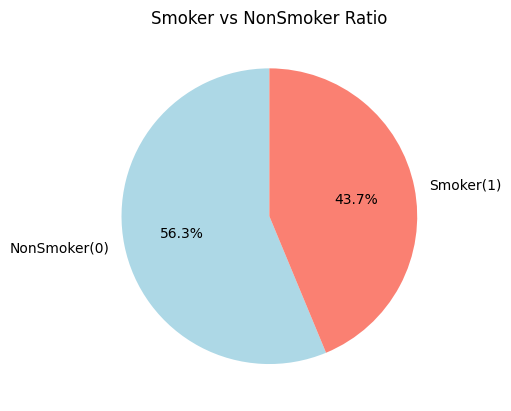

In [ ]:
# Target 비율 확인 - 시각화
train_df['smoking'].value_counts().plot.pie(
    labels=['NonSmoker(0)', 'Smoker(1)'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Smoker vs NonSmoker Ratio')
plt.ylabel('')
plt.show()

타겟 변수의 분포는 비교적 균형에 가까운 분포를 보인다.
- 비흡연자(NonSmoker=0) 53.6%
- 흡연자(Smoker=1) 43.7%  

<br>

## 1.3 타깃 변수와의 관계 분석


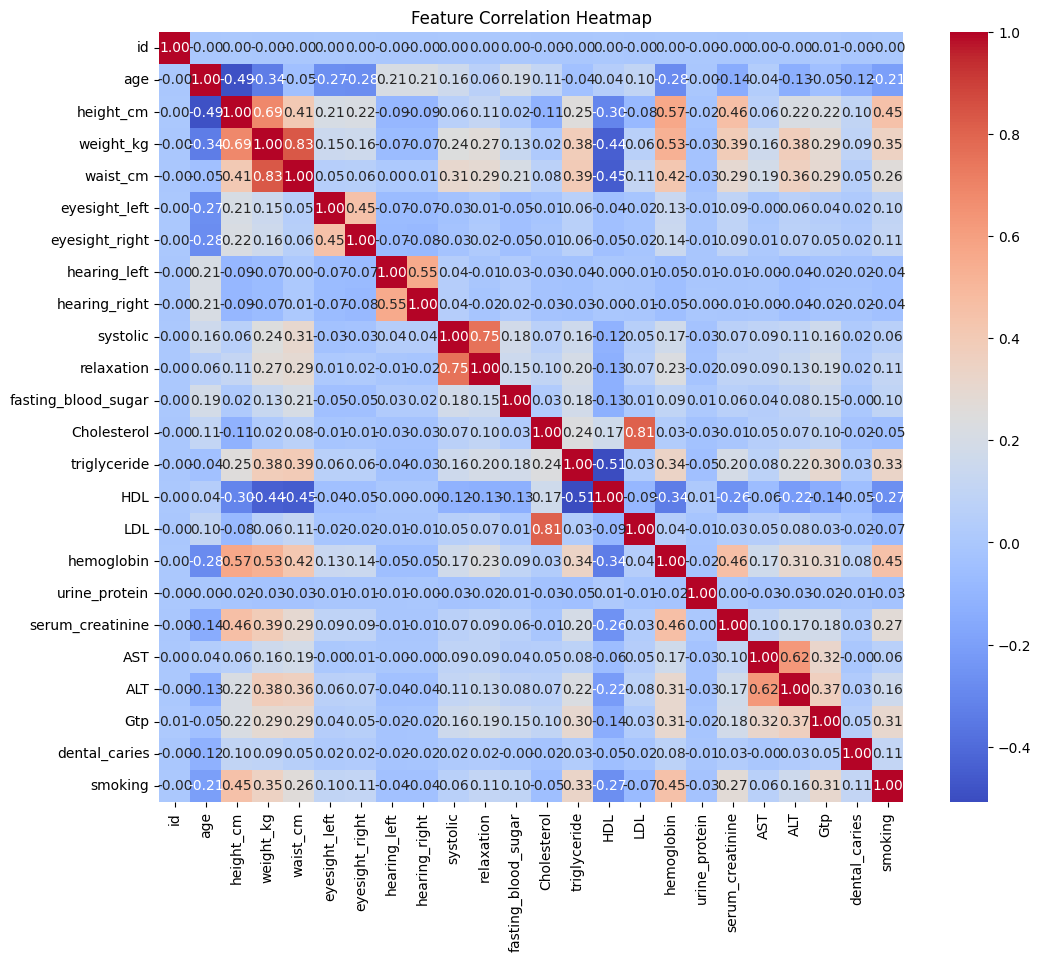

In [ ]:
# 상관계수 행렬 계산
corr_matrix = train_df.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

**타겟변수와의 상관관계 Top6**
 1. hemoglobin +0.45
 2. height_cm +0.45
 3. weight_kg +0.35
 4. triglyceride +0.33
 5. waist_cm +0.26
 6. HDL -0.27
 7. Gtp +0.26
  
흡연 여부가 체형, 혈중 지질, 간 기능 등의 지표들과 비교적 유의한 상관관계를 보이나,  
생각보다 크게 유의미한 지표(0.5 이상)는 없다.  
=> Feature Engineering의 필요성 고려

<br>

## 1.4 변수 분포 시각화 (범주형/수치형)

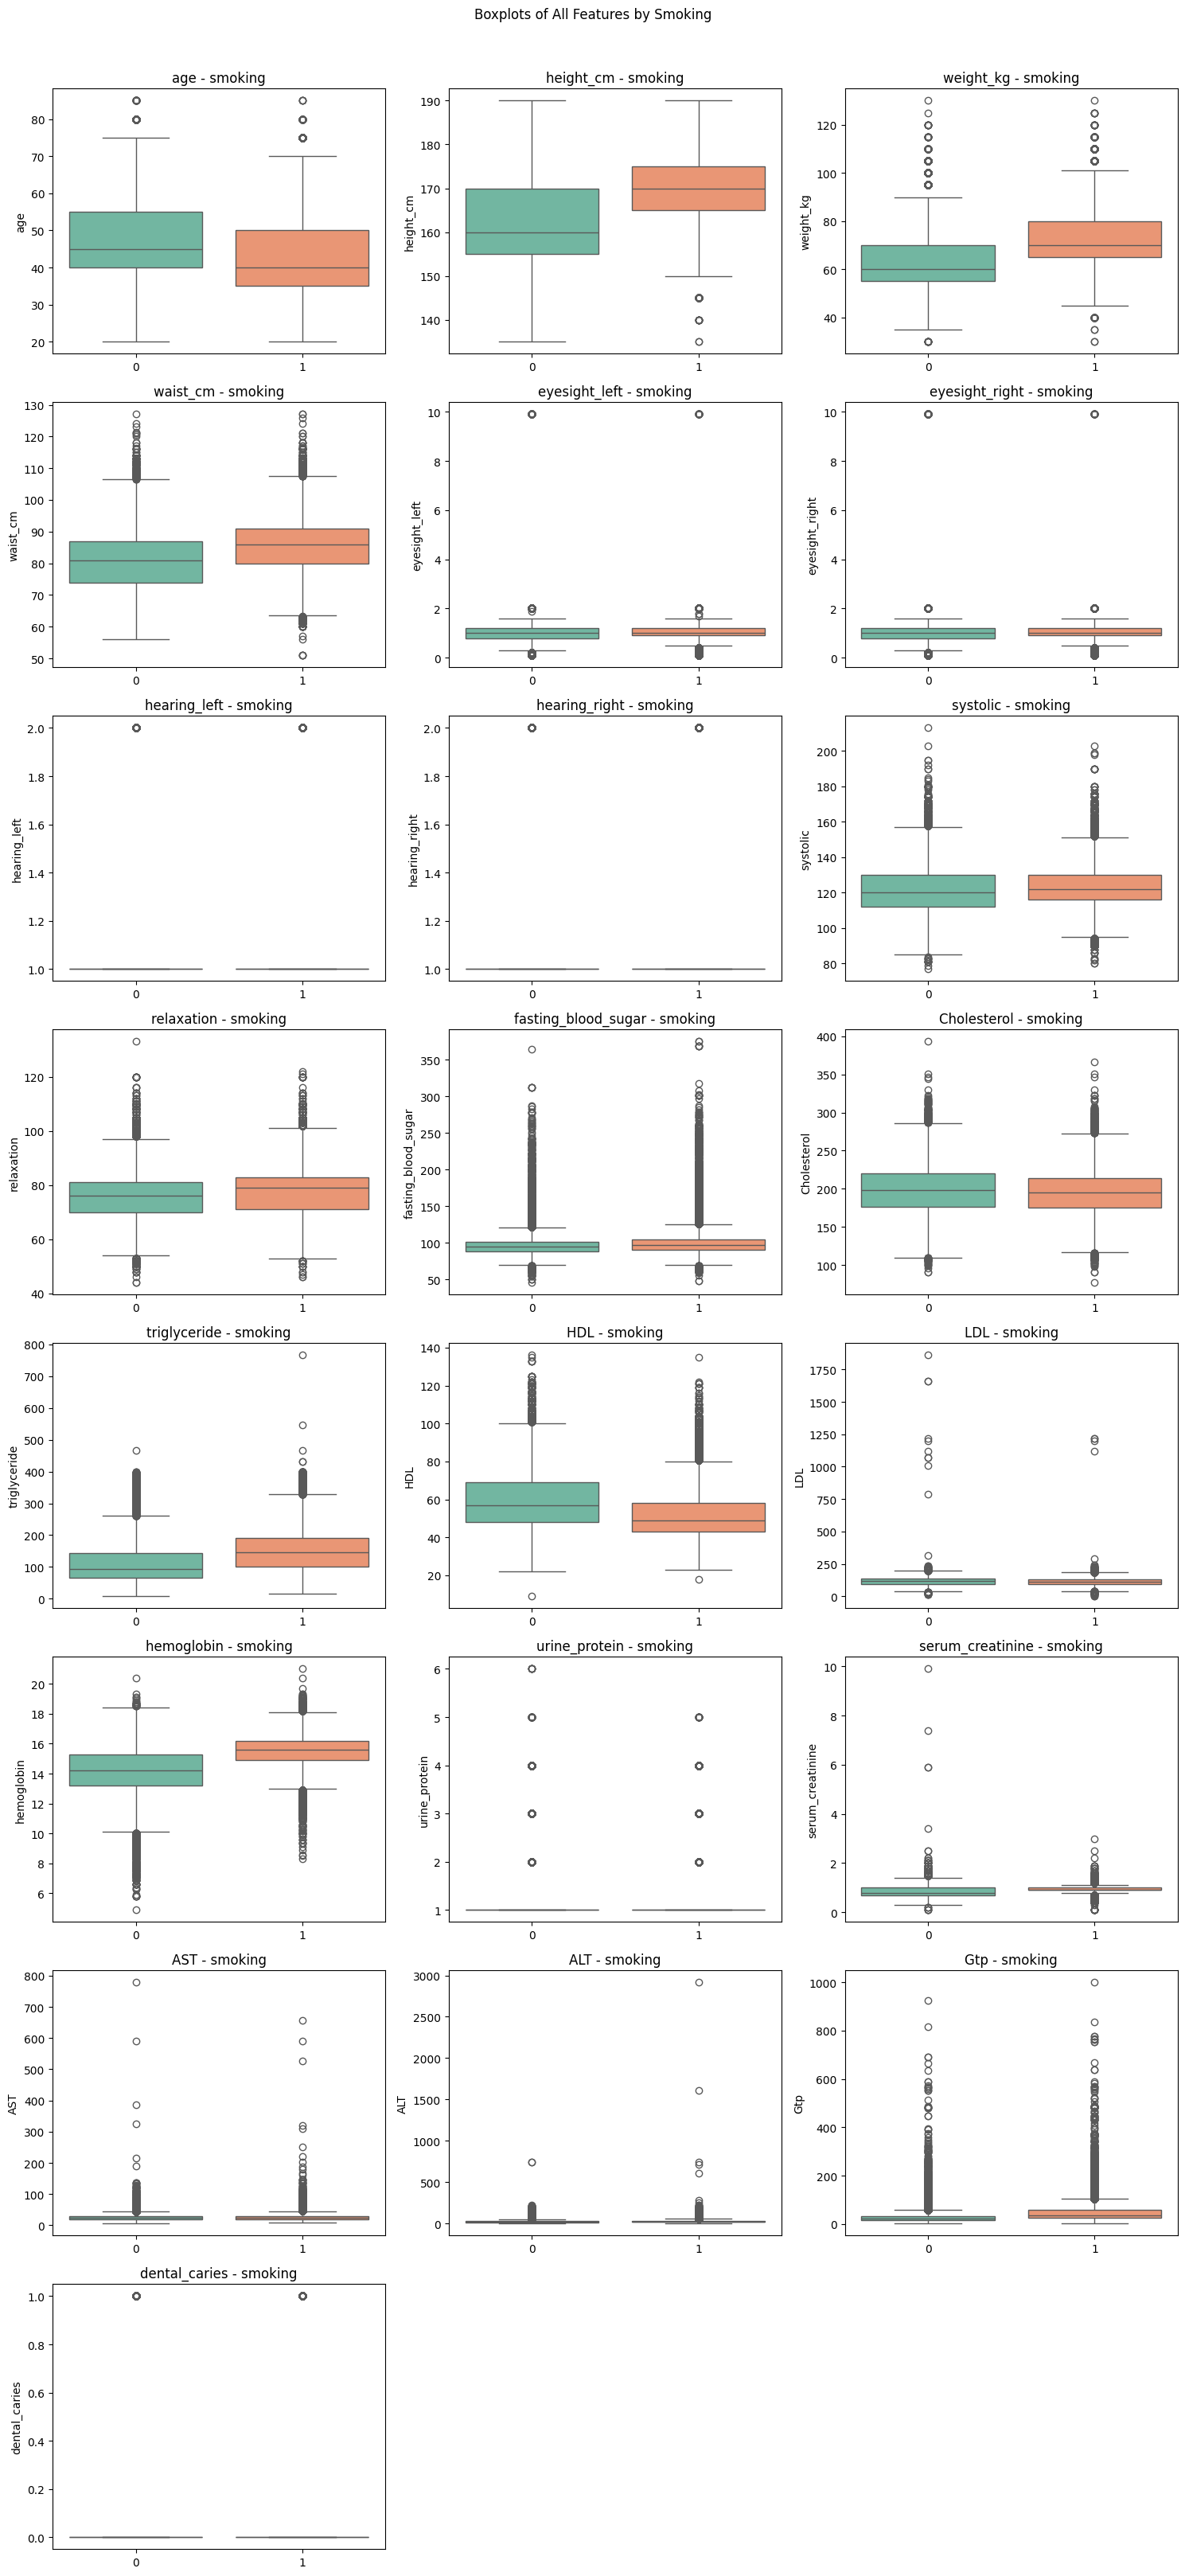

In [ ]:
## boxplot
# 1. id와 smoking은 제외하고 모든 피처 선택
features = train_df.drop(columns=['id', 'smoking']).columns

# 2. subplot의 행/열
n_features = len(features)                    # 피처 개수
n_cols = 3                                    # 열 개수: 한 행에 몇 개의 그래프 그릴지
n_rows = (n_features + n_cols -1) // n_cols   # 필요한 행 개수

# 3. 캔버스 크기
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# 4. 각 피처에 대해 반복하여 subplot에 boxplot 그리기
for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)  # (행, 열, 현재 순번)에 맞는 subplot 위치 지정
    sns.boxplot(                   # boxplot으로 피처별 분포 시각화
        data=train_df,
        x='smoking',               # x축은 흡연 여부 (0 or 1)
        y=col,                     # y축은 해당 피처의 값
        palette='Set2'
    )
    plt.title(f'{col} - smoking')   # 그래프 제목
    plt.xlabel('')                  # x축 레이블 생략 (0, 1로만 표현)
    plt.tight_layout()

plt.suptitle("Boxplots of All Features by Smoking", y=1.01)

plt.tight_layout()
plt.show()

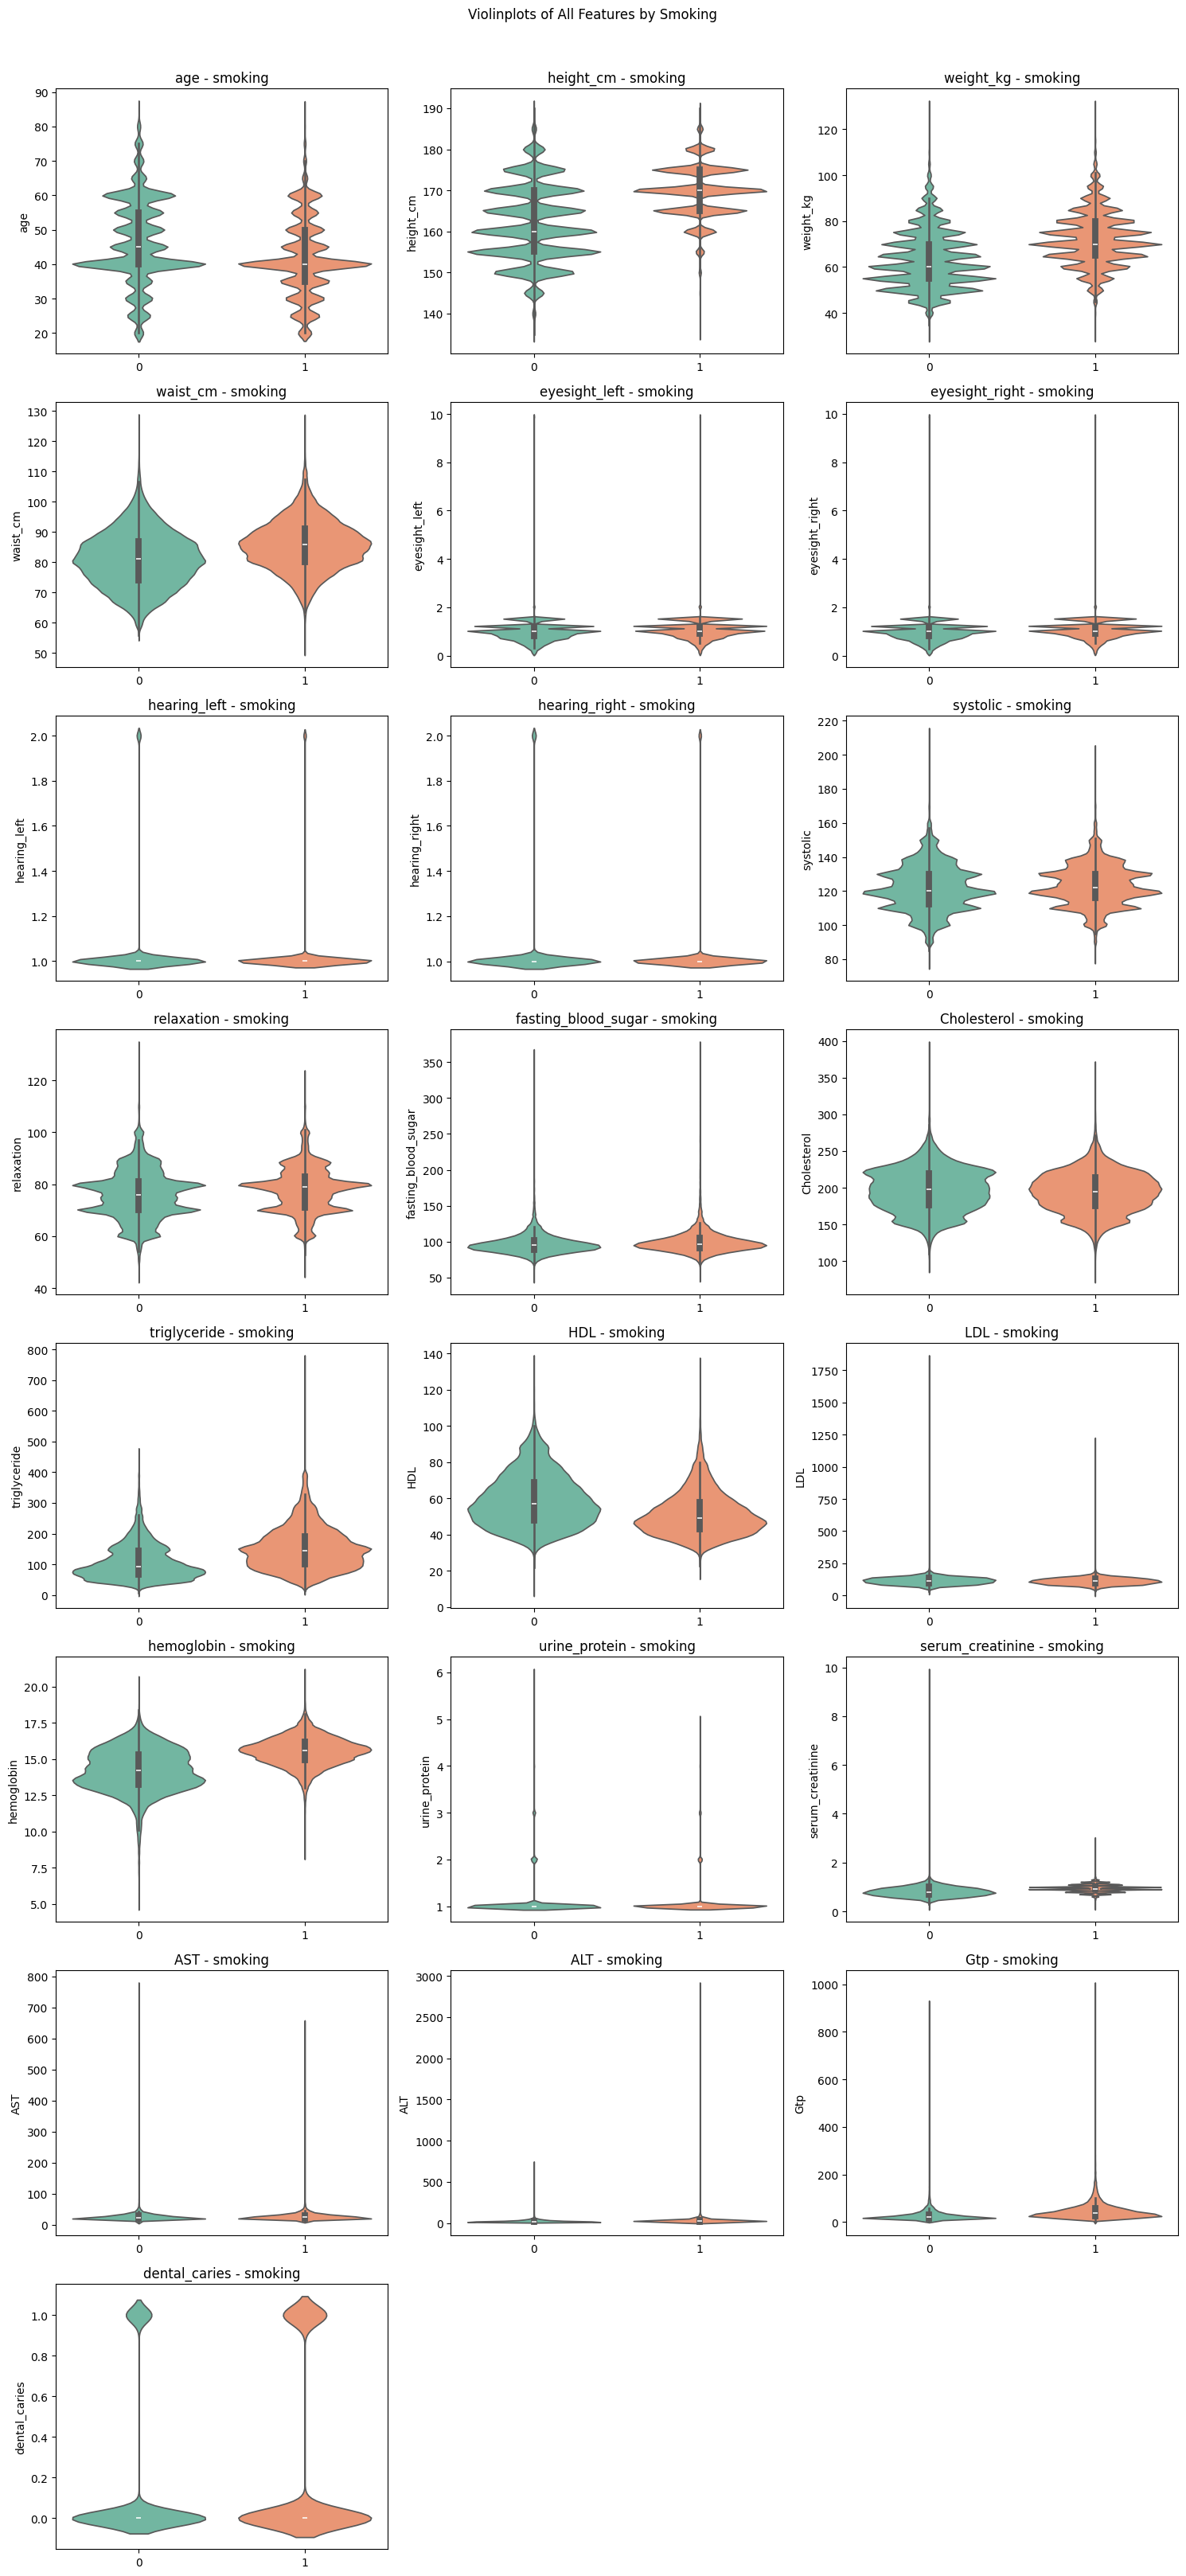

In [ ]:
## Violinplot
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=train_df, x='smoking', y=col, palette='Set2', inner='box')
    plt.title(f'{col} - smoking')
    plt.xlabel('')
    plt.tight_layout()

plt.suptitle('Violinplots of All Features by Smoking', y=1.01)
plt.tight_layout()
plt.show()

**피처별 박스플롯&바이올릿플롯 해석**

| 피처                                   | 해석                                           |
| ------------------------------------ | ----------------------------------------------- |
| height(cm)                       | 흡연자 그룹이 전반적으로 키가 더 크고, 분포가 더 좁게 집중됨         |
| weight(kg)                       | 흡연자 쪽이 약간 더 무거움            |
| waist(cm)                        | 흡연자 쪽 허리둘레가 큼                           |
| systolic / relaxation (혈압)       | 흡연자 쪽이 중앙값도 높고 분포도 우측으로 더 퍼져 있음             |
| Gtp / ALT / AST (간수치)            | 흡연자 쪽에 긴 꼬리(극단치)와 분포 중심 상승 → 간 기능 관련 이상 가능성 |
| LDL / Cholesterol / triglyceride | 흡연자가 높은 밀도 중심 + 더 많은 고지혈 이상치 존재             |
| HDL                 | 흡연자에서 좋은 콜레스테롤(HDL)이 더 낮음 → 일반적 생리학 패턴과 일치함 |
| fasting blood sugar | 흡연자 쪽이 약간 더 높고 이상치 더 많음, 하지만 완전히 구분되진 않음        |
| hemoglobin          | 흡연자가 살짝 더 높은 중앙값을 가짐 → 만성 저산소증 보상 가능성 있음            |

<br>

## 1.5 상관관계 분석

In [ ]:
## 다중공선성 확인 - VIF(Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 수치형 변수만 선택
X = train_df.drop(columns=['smoking'])  # 타겟 제외

# 상수항 추가
X = add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df.sort_values('VIF', ascending=False))

                feature          VIF
0                 const  1244.431309
13          Cholesterol     7.333379
4             weight_kg     6.801537
16                  LDL     6.107157
5              waist_cm     4.588011
15                  HDL     3.221739
14         triglyceride     3.001240
3             height_cm     2.914232
10             systolic     2.456500
11           relaxation     2.409581
21                  ALT     1.986468
17           hemoglobin     1.848829
2                   age     1.819872
20                  AST     1.742144
9         hearing_right     1.465960
8          hearing_left     1.464441
19     serum_creatinine     1.405493
22                  Gtp     1.335092
7        eyesight_right     1.303434
6         eyesight_left     1.295456
12  fasting_blood_sugar     1.126582
23        dental_caries     1.021530
18        urine_protein     1.005057
1                    id     1.000136


In [ ]:
## 어떤 피처끼리 상관관계가 있는지 확인
# 절댓값 기준으로 상관관계 높은 쌍만 추출
threshold = 0.6    # 조절 가능
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # np.ones로 전부 1인 행렬 만들고 → np.triu로 위쪽 삼각형(대각선 포함)만 남기기
    # k=1은 대각선은 제외하고 위쪽만 True로 설정
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
    .query('abs(Correlation) > @threshold')
    .sort_values(by='Correlation', ascending=False)
)

high_corr_pairs

Feature 1   Feature 2  Correlation
66     weight_kg    waist_cm     0.830208
212  Cholesterol         LDL     0.808533
171     systolic  relaxation     0.753003
45     height_cm   weight_kg     0.686645
266          AST         ALT     0.623408

- 다중공선성이 5이상인 피처 [5이상이면 주의 및 확인 권장 수치]
  - Cholesterol: 7.333379
  - weight(kg): 6.801537
  - LDL: 6.107157
- 각 피처들이 어떤 피처와 연관이 있는지 확인 [0.6이상]
  - weight(kg) - waist(cm)
  - Cholesterol - LDL
  - systolic - relaxion
  - height(cm) - weight(kig)
  - AST - ALT

In [ ]:
# 동일한 상관관계 heatmap을 Plotly로 구현
fig = px.imshow(corr_matrix,
                text_auto='.2f',
                color_continuous_scale='RdBu_r',
                zmin=-1, zmax=1,
                title='Interactive Correlation Heatmap')
fig.show()

<br>
<br>

# 2. 데이터 엔지니어링

## 2.1 결측치, 이상치 확인 및 처리

*   결측치 없음
*   이상치 확인

    -  eyesight(left/right) 시력 수치 => 9.9는 데이터 오류 => **2로 수정**
    -  triglyceride 중성지방 최대값: 766 => 고지혈증 의심
    -  LDL 300 이상 데이터 오류=> **300으로 처리**
    -  hemoglobin =>고산 지대 적응자 산소 부족 보상으로 혈색소 증가 가능
    -  serum creatinine => 9.9 말기신부전 / 대부분 투석 중이거나 직전 상태
    -  ALT, AST 이상치 => 독성 간염, 약물 유발성 손상 1,000 U/L까지 가능하고 그 이상은 데이터 오류로 판단
    -  Gtp 500 ~ 999 => 중증 간질환, 알코올성 간질환, 간종양, 담관 폐쇄 등 가능
* 이상치 처리 (데이터 오류)
 - eyesight(left/right) : 9.9 => 2
 - LDL : 300 초과 => 300
 - ALT : 1,000 초과 => 1,000



**eyesight(left/right) 시력 수치 => 9.9는 데이터 오류 => 2로 수정**

In [ ]:
# test용 - 추후 셀 제거
# train_df = pd.read_csv('/content/drive/MyDrive/DS/Datathon/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/DS/Datathon/test.csv')
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Smokalyzer/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Smokalyzer/test.csv')

# 컬럼명 표준화
rename_columns = {
    'height(cm)': 'height_cm',
    'weight(kg)': 'weight_kg',
    'waist(cm)': 'waist_cm',
    'eyesight(left)': 'eyesight_left',
    'eyesight(right)': 'eyesight_right',
    'hearing(left)': 'hearing_left',
    'hearing(right)': 'hearing_right',
    'fasting blood sugar': 'fasting_blood_sugar',
    'serum creatinine': 'serum_creatinine',
    'Urine protein': 'urine_protein',
    'dental caries': 'dental_caries'
}

train_df.rename(columns=rename_columns, inplace=True)
test_df.rename(columns=rename_columns, inplace=True)

In [ ]:
# 시력값 상한 처리: 2.0 초과 값은 2.0으로 클리핑
max_eyesight = 2.0

# 변환 전 2.0 초과 데이터 개수 확인
left_exceed = train_df[train_df['eyesight_left'] > max_eyesight].shape[0]
right_exceed = train_df[train_df['eyesight_right'] > max_eyesight].shape[0]

print(f'2.0 초과 시력 (왼쪽): {left_exceed}개')
print(f'2.0 초과 시력 (오른쪽): {right_exceed}개')

# 클리핑 처리
train_df['eyesight_left'] = train_df['eyesight_left'].clip(upper=max_eyesight)
train_df['eyesight_right'] = train_df['eyesight_right'].clip(upper=max_eyesight)
test_df['eyesight_left'] = test_df['eyesight_left'].clip(upper=max_eyesight)
test_df['eyesight_right'] = test_df['eyesight_right'].clip(upper=max_eyesight)

# 처리 후 데이터 개수 확인 (선택적)
left_valid = train_df[train_df['eyesight_left'] <= max_eyesight].shape[0]
right_valid = train_df[train_df['eyesight_right'] <= max_eyesight].shape[0]
print(f'변환 후 왼쪽 시력 ≤ 2.0: {left_valid}개')
print(f'변환 후 오른쪽 시력 ≤ 2.0: {right_valid}개')

2.0 초과 시력 (왼쪽): 132개
2.0 초과 시력 (오른쪽): 117개
변환 후 왼쪽 시력 ≤ 2.0: 159256개
변환 후 오른쪽 시력 ≤ 2.0: 159256개


**LDL 300 이상 데이터 오류=> 300으로 처리**

In [ ]:
# LDL 수치 상한값 설정 및 이상치 처리
ldl_threshold = 300

# 처리 전 이상치 개수 확인
ldl_exceed = train_df[train_df['LDL'] > ldl_threshold].shape[0]
print(f'처리 전 300 초과 LDL 수치 개수: {ldl_exceed}개')

# 이상치 클리핑 처리
train_df['LDL'] = train_df['LDL'].clip(upper=ldl_threshold)
test_df['LDL'] = test_df['LDL'].clip(upper=ldl_threshold)

# 처리 후 정상 범위 내 데이터 수 확인 (선택적)
ldl_valid = train_df[train_df['LDL'] <= ldl_threshold].shape[0]
print(f'처리 후 300 이하 LDL 수치 개수: {ldl_valid}개')

처리 전 300 초과 LDL 수치 개수: 15개
처리 후 300 이하 LDL 수치 개수: 159256개


In [ ]:
train_df[train_df['ALT'] > 1000].shape[0]

train_df['ALT'] = train_df['ALT'].clip(upper=1000)
test_df['ALT'] = test_df['ALT'].clip(upper=1000)

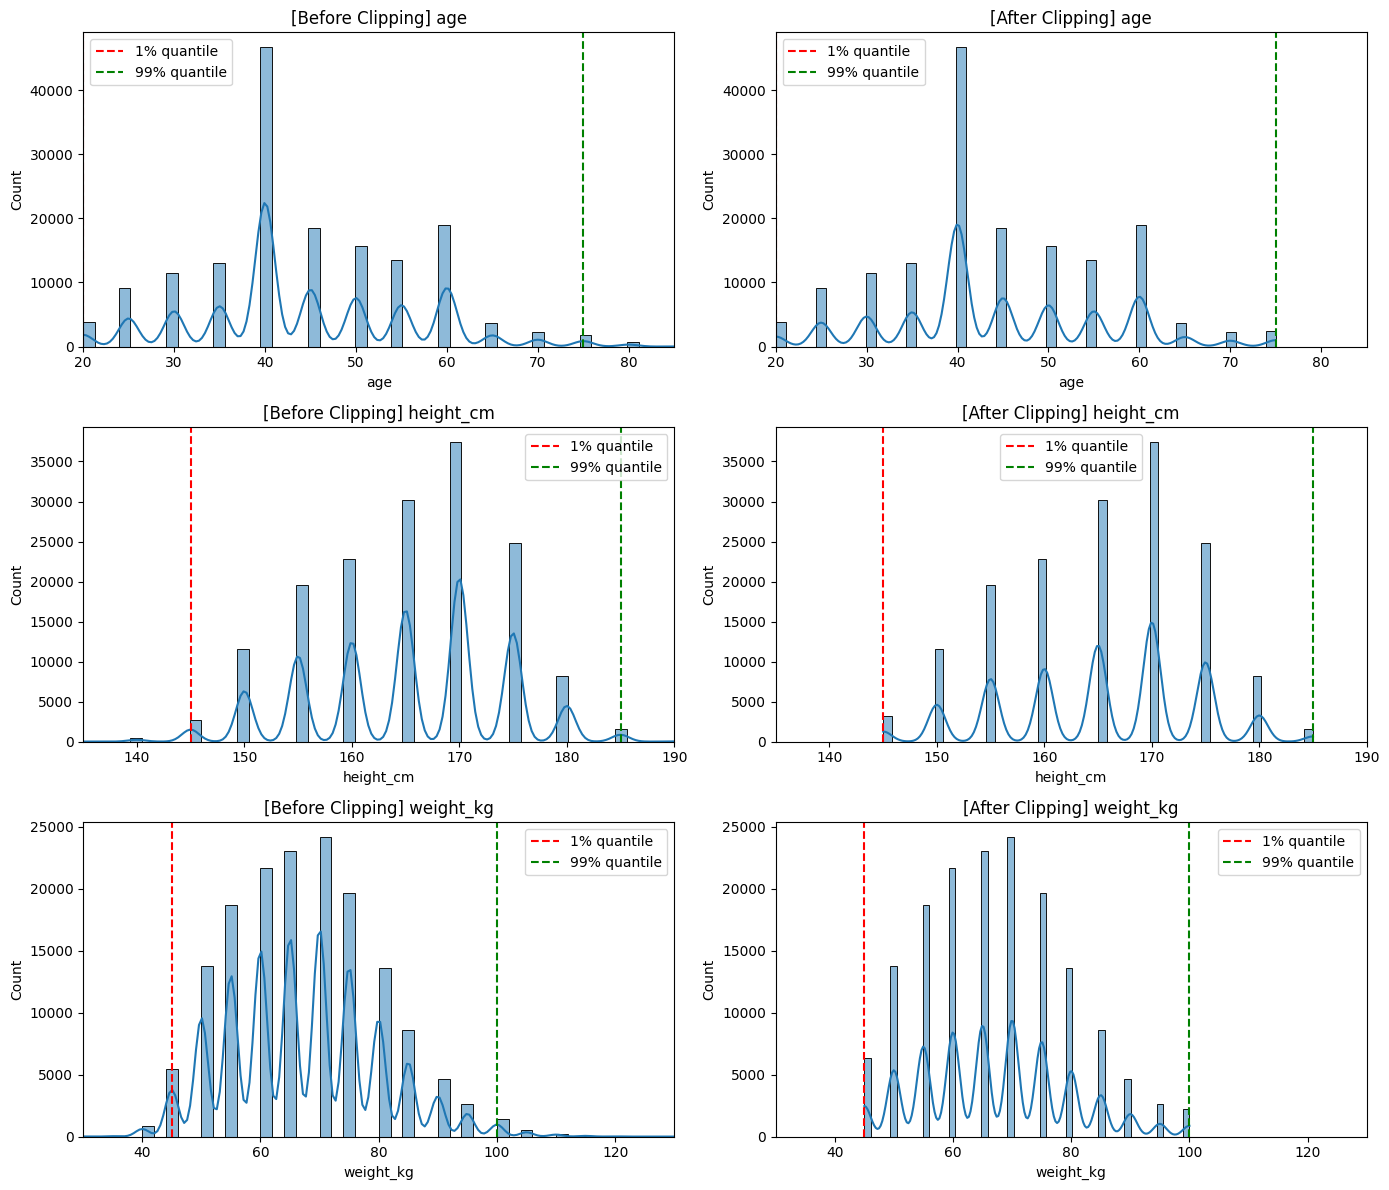

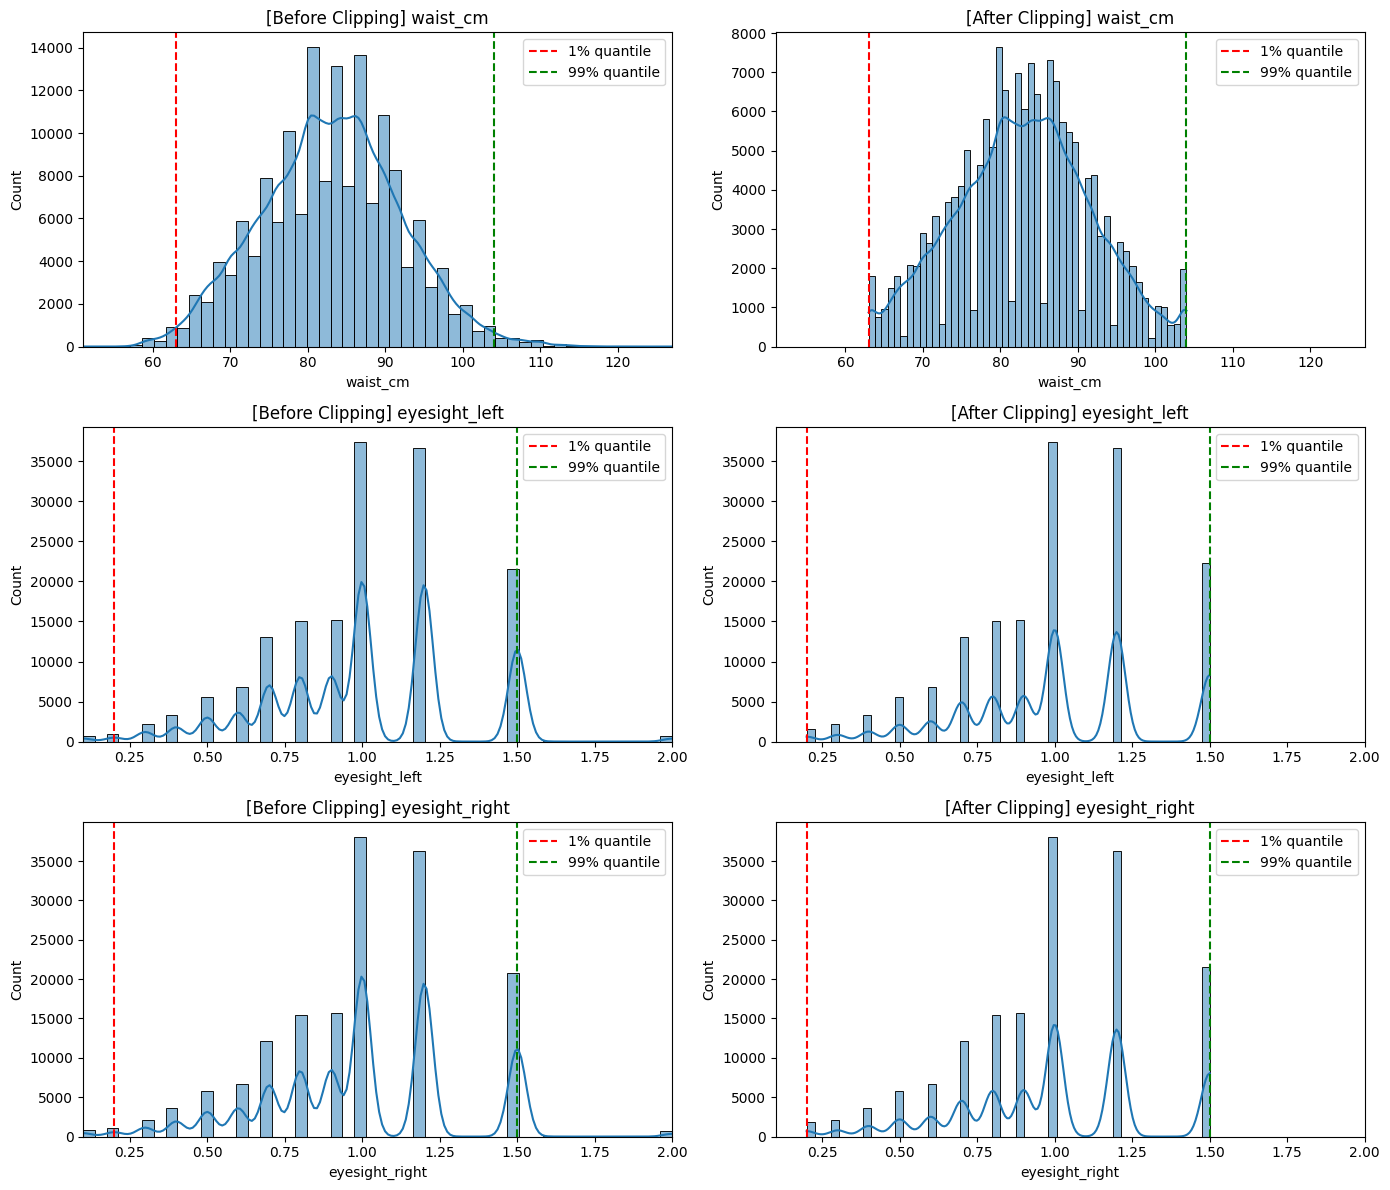

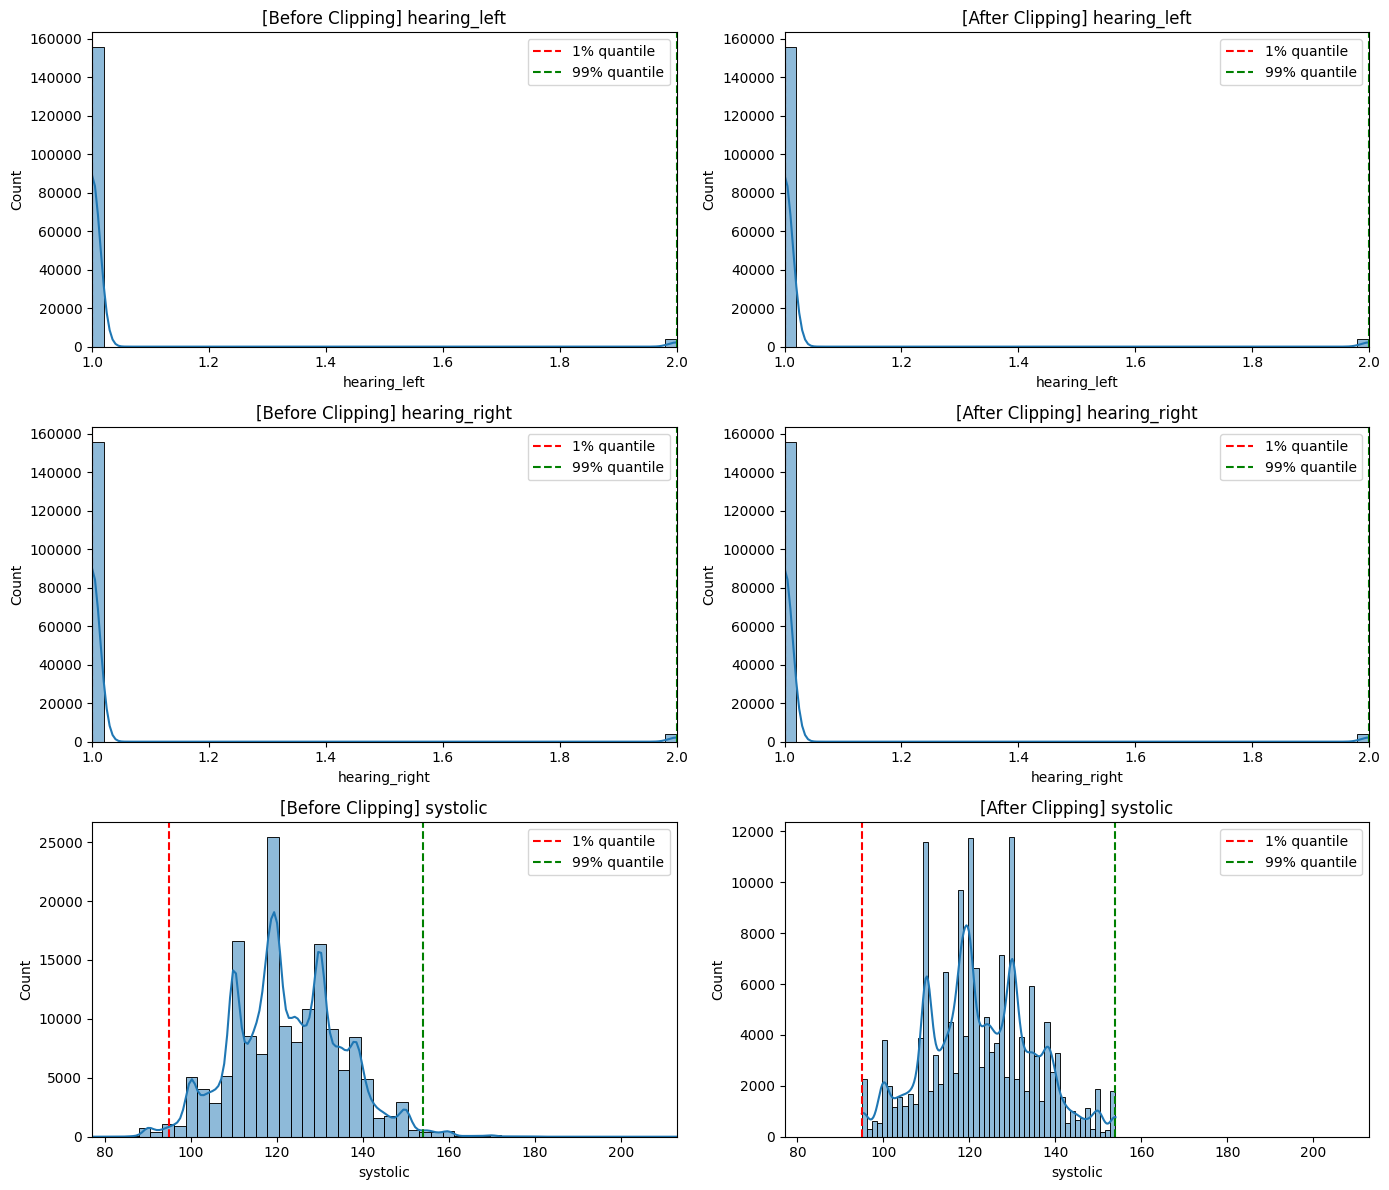

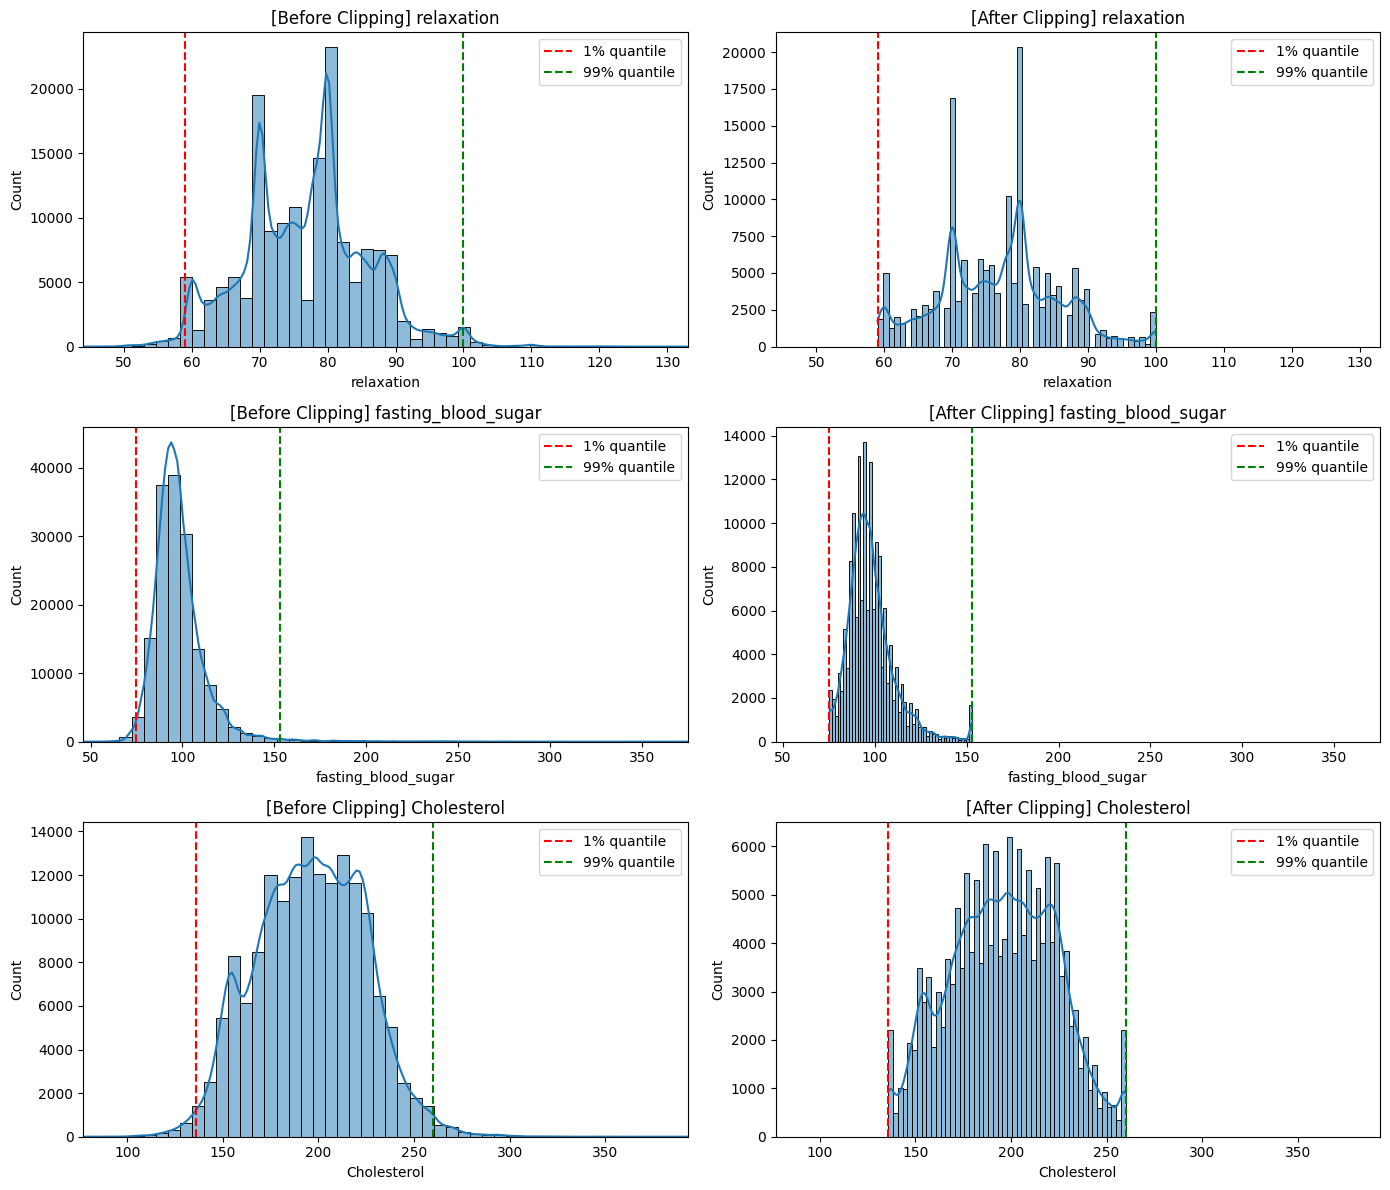

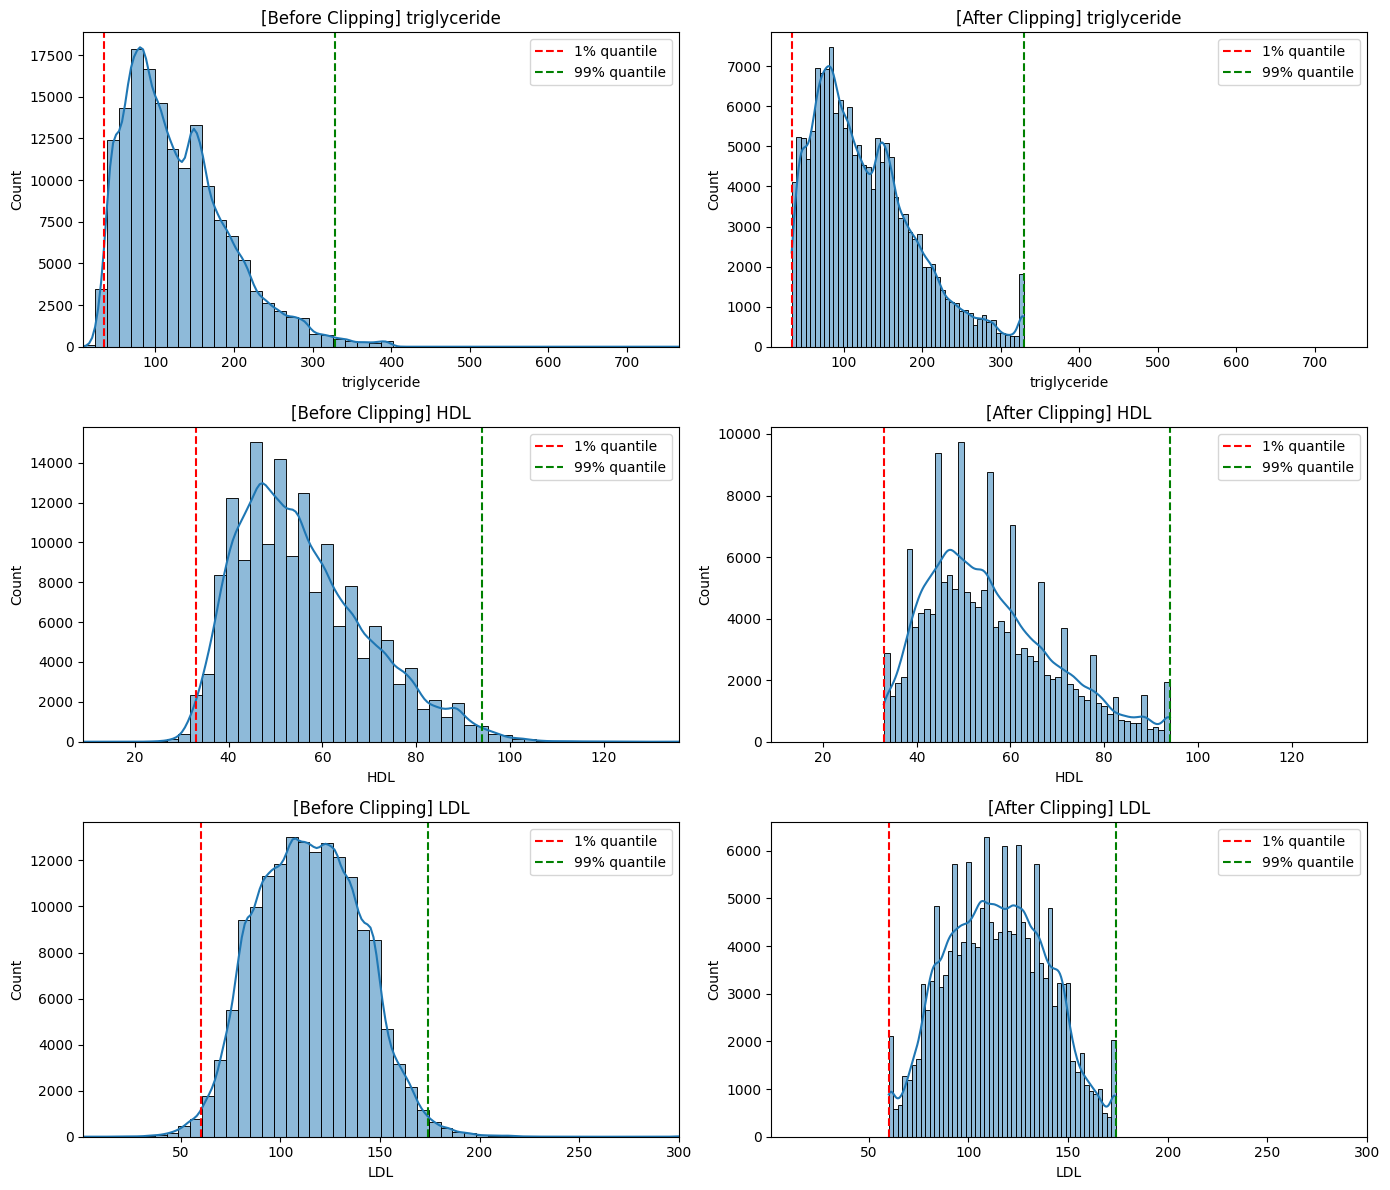

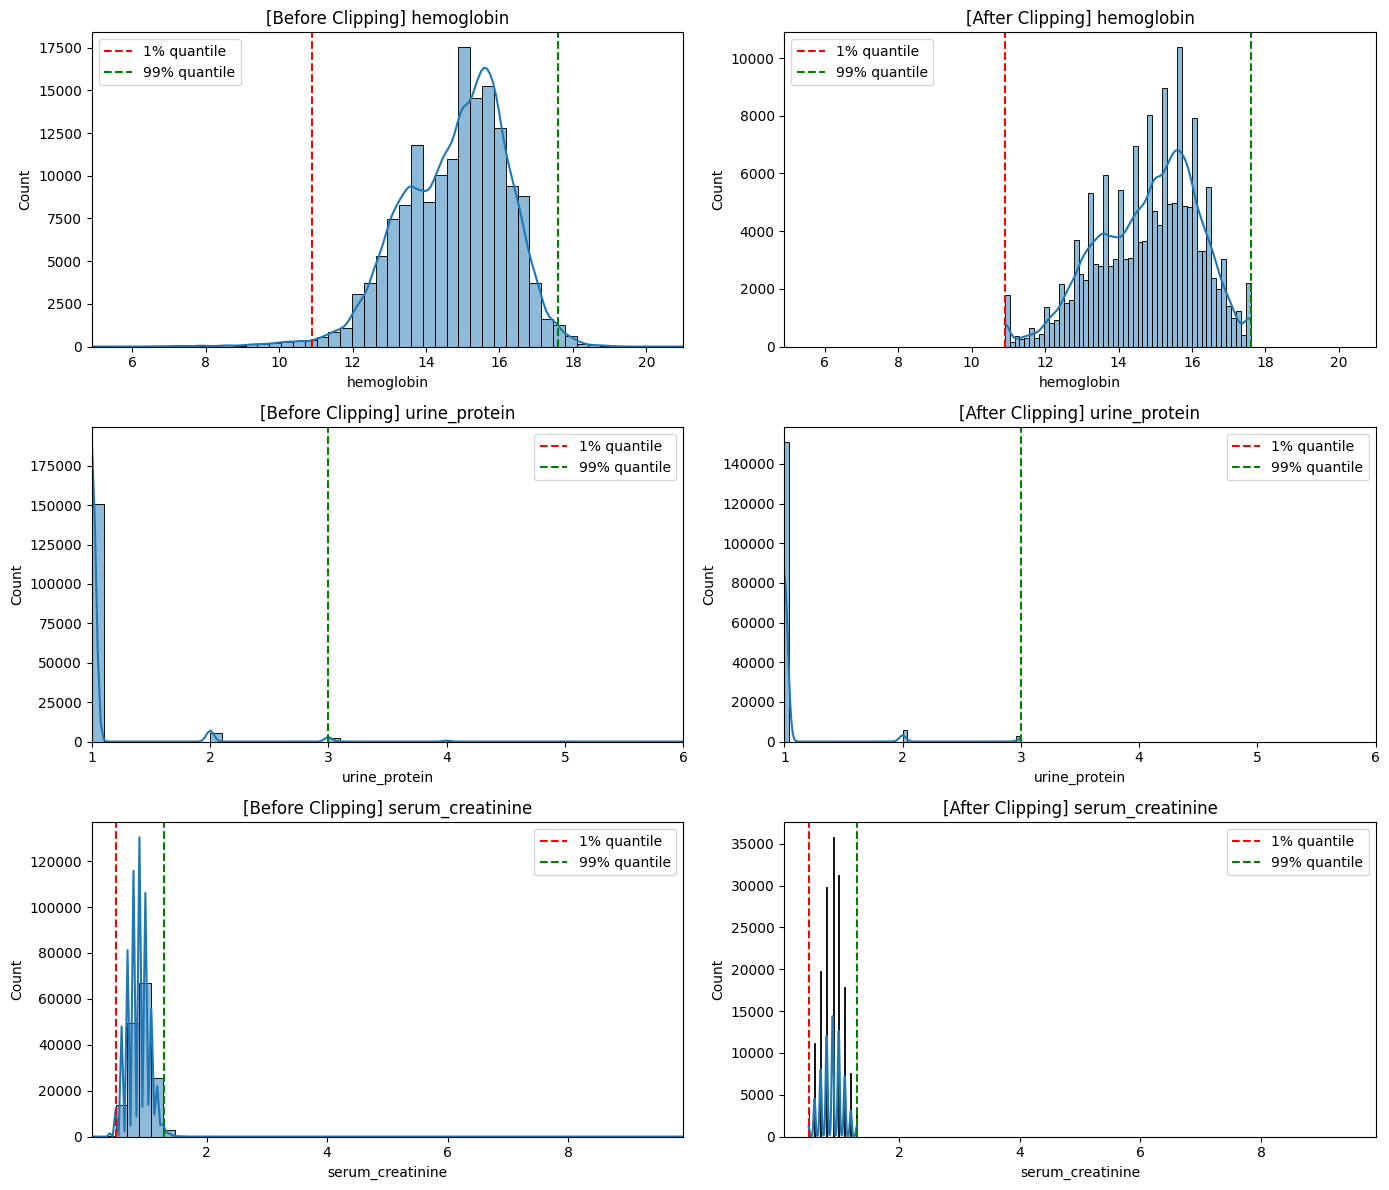

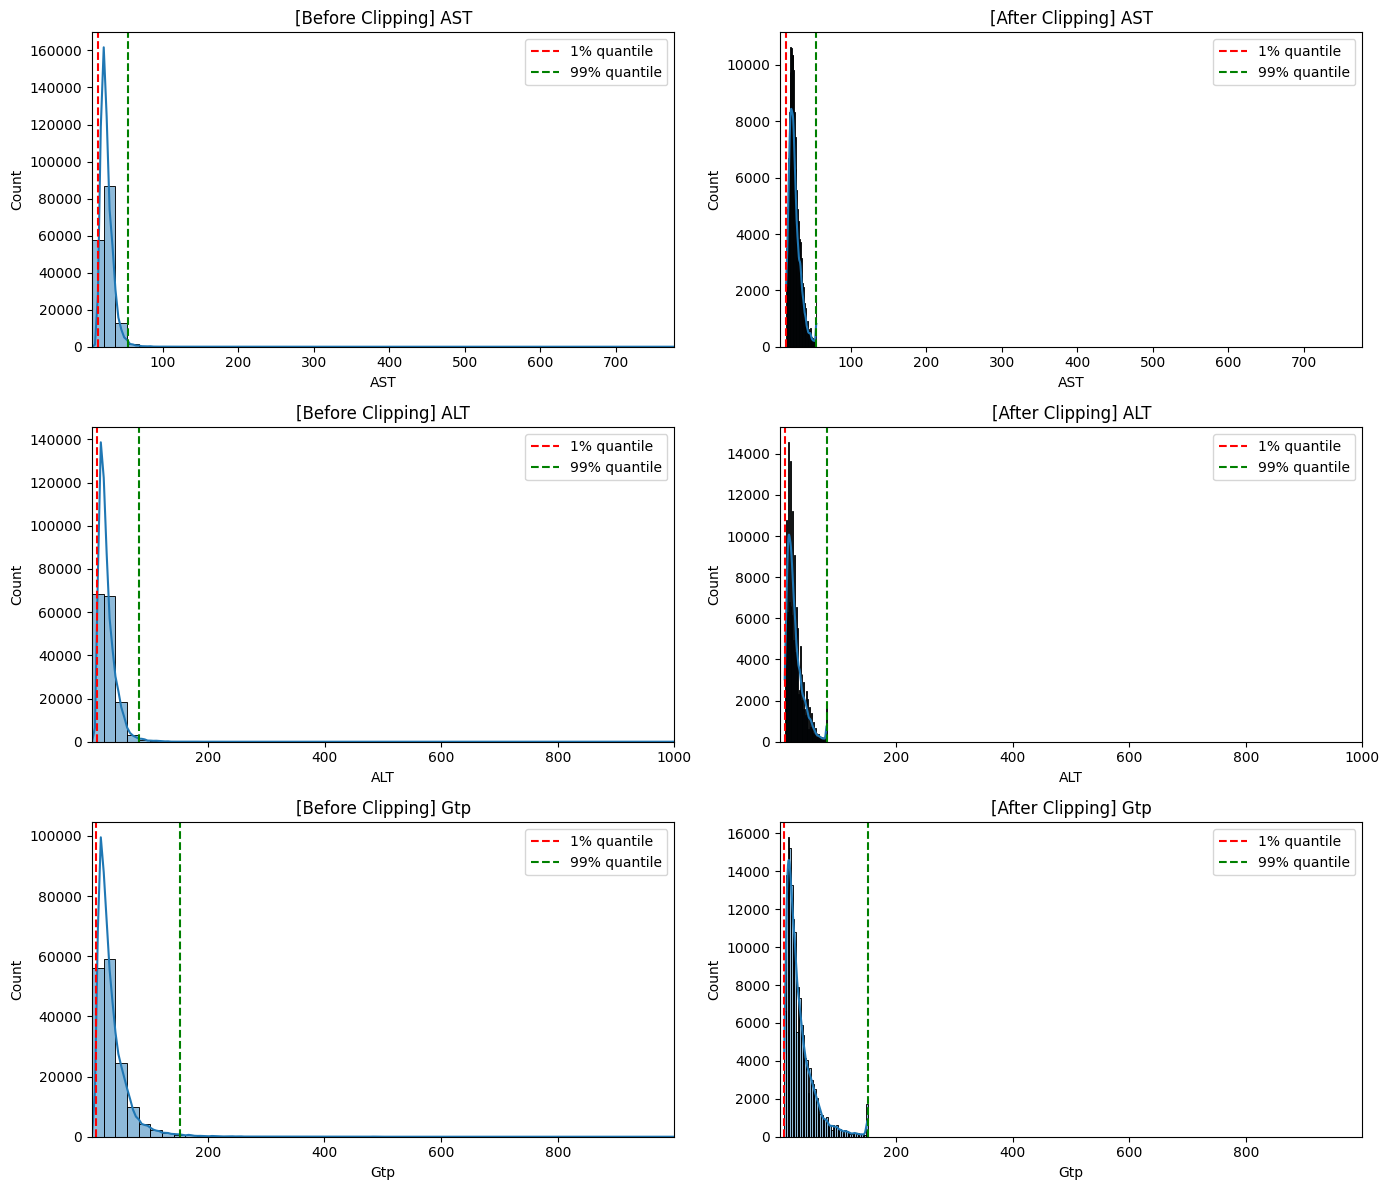

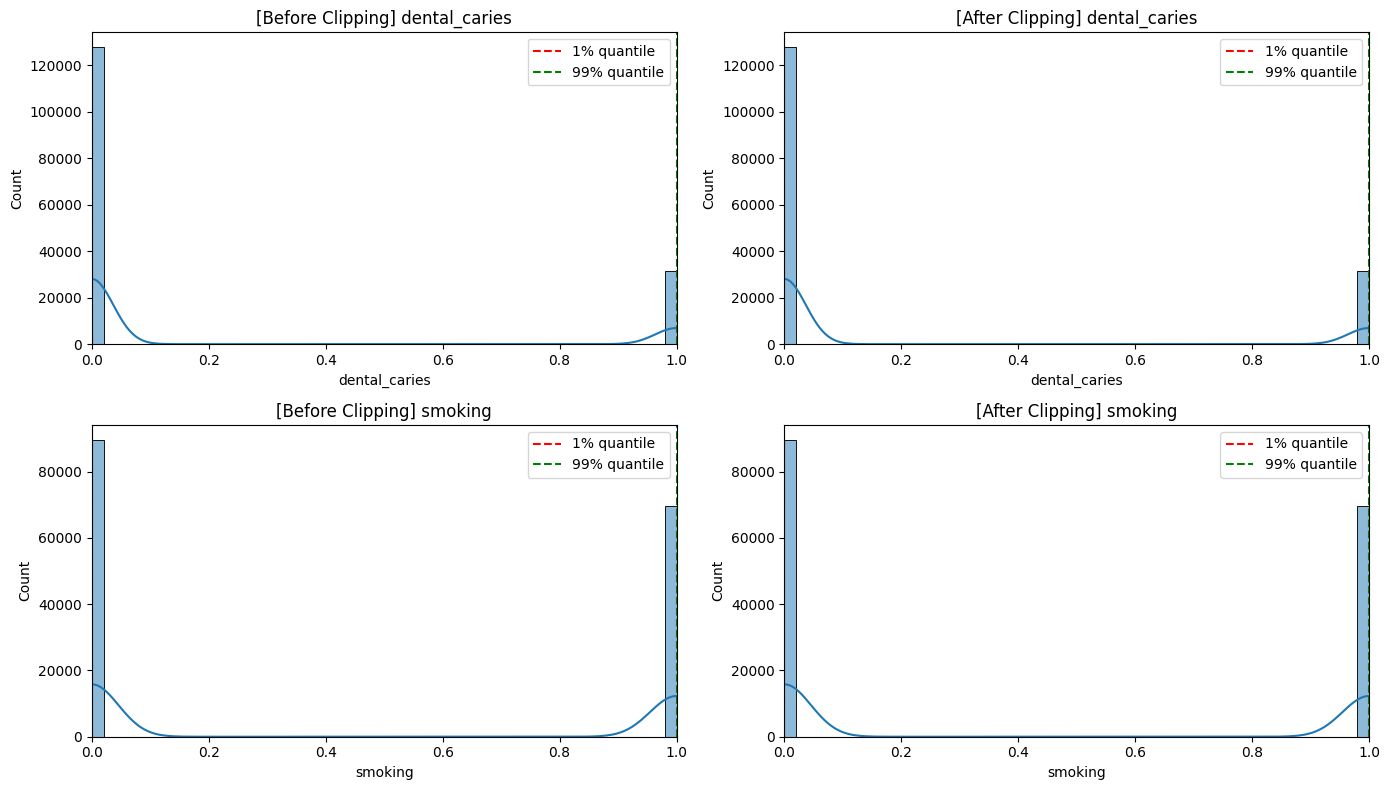

In [ ]:
# 이상치 클리핑

import matplotlib.pyplot as plt
import seaborn as sns
import math

# 'id' 제외
numerical_cols = [
    col for col in train_df.columns
    if (train_df[col].dtype in ['int64', 'float64']) and (col != 'id')
]

# 클리핑 전 백업
train_df_before = train_df.copy()
test_df_before = test_df.copy()

# 클리핑 수행
clip_bounds = {}
for col in numerical_cols:
    lower = train_df[col].quantile(0.01)
    upper = train_df[col].quantile(0.99)
    clip_bounds[col] = (lower, upper)
    train_df[col] = train_df[col].clip(lower, upper)
    if col in test_df.columns:
        test_df[col] = test_df[col].clip(lower, upper)

# 시각화 (3개씩 나눠서)
cols_per_page = 3
num_cols = len(numerical_cols)
num_pages = math.ceil(num_cols / cols_per_page)

for page in range(num_pages):
    start = page * cols_per_page
    end = min(start + cols_per_page, num_cols)
    sub_cols = numerical_cols[start:end]

    fig, axes = plt.subplots(len(sub_cols), 2, figsize=(14, 4 * len(sub_cols)))
    if len(sub_cols) == 1:
        axes = [axes]  # 1개일 때 처리

    for i, col in enumerate(sub_cols):
        lower, upper = clip_bounds[col]
        xmin = min(train_df_before[col].min(), train_df[col].min())
        xmax = max(train_df_before[col].max(), train_df[col].max())

        # Before Clipping
        sns.histplot(train_df_before[col], bins=50, kde=True, ax=axes[i][0])
        axes[i][0].axvline(lower, color='red', linestyle='--', label='1% quantile')
        axes[i][0].axvline(upper, color='green', linestyle='--', label='99% quantile')
        axes[i][0].set_title(f'[Before Clipping] {col}')
        axes[i][0].set_xlim(xmin, xmax)
        axes[i][0].legend()

        # After Clipping
        sns.histplot(train_df[col], bins=50, kde=True, ax=axes[i][1])
        axes[i][1].axvline(lower, color='red', linestyle='--', label='1% quantile')
        axes[i][1].axvline(upper, color='green', linestyle='--', label='99% quantile')
        axes[i][1].set_title(f'[After Clipping] {col}')
        axes[i][1].set_xlim(xmin, xmax)
        axes[i][1].legend()

    plt.tight_layout()
    plt.show()

<br>

## 2.2 피처 엔지니어링(컬럼 생성,삭제 등)

### 2.2.1 Gender

In [ ]:
# 원본 데이터셋을 이용해서 gender 피처 생성
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download('kukuroo3/body-signal-of-smoking')

smoking_orig = pd.read_csv(path + '/' + os.listdir(path)[0])
print(smoking_orig.info())
smoking_orig.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

ID gender  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0      F   40         155          60       81.3             1.2   
1   1      F   40         160          60       81.0             0.8   
2   2      M   55         170          60       80.0             0.8   
3   3      M   40         165          70       88.0             1.5   
4   4      F   40         155          60       86.0             1.0   

   eyesight(right)  hearing(left)  hearing(right)  ...  hemoglobin  \
0              1.0            1.0             1.0  ...        12.9   
1              0.6            1.0             1.0  ...        12.7   
2              0.8            1.0             1.0  ...        15.8   
3              1.5            1.0             1.0  ...        14.7   
4              1.0            1.0             1.0  ...        12.5   

   Urine protein  serum creatinine   AST   ALT   Gtp  oral  dental caries  \
0            1.0               0.7  18.0  19.0  27.0     Y              0   
1            1.0               0.6  22.0  19.0  18.0     Y              0   
2            1.0               1.0  21.0  16.0  22.0     Y              0   
3            1.0               1.0  19.0  26.0  18.0     Y              0   
4            1.0               0.6  16.0  14.0  22.0     Y              0   

   tartar  smoking  
0       Y        0  
1       Y        0  
2       N        1  
3       Y        0  
4       N        0  

[5 rows x 27 columns]

In [ ]:
new_features = []

In [ ]:
smoking_orig.columns

Index(['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental caries',
       'tartar', 'smoking'],
      dtype='object')

In [ ]:
# 컬럼명 표준화
rename_columns = {
    'ID':'id',
    'height(cm)': 'height_cm',
    'weight(kg)': 'weight_kg',
    'waist(cm)': 'waist_cm',
    'eyesight(left)': 'eyesight_left',
    'eyesight(right)': 'eyesight_right',
    'hearing(left)': 'hearing_left',
    'hearing(right)': 'hearing_right',
    'fasting blood sugar': 'fasting_blood_sugar',
    'serum creatinine': 'serum_creatinine',
    'Urine protein': 'urine_protein',
    'dental caries': 'dental_caries'
}

smoking_orig.rename(columns=rename_columns, inplace=True)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# gender 예측을 위한 입력 데이터(X)와 타겟(y) 정의
X_0 = smoking_orig.drop(columns=['gender', 'oral', 'tartar', 'smoking'])  # 예측에 불필요한 컬럼 제거. oral-구강검진 여부/tartar-치석상태 검진
y_0 = smoking_orig['gender'].map({'F': 0, 'M': 1})  # 성별 문자 → 숫자로 인코딩 (F:0, M:1)

# Stratified K-Fold 교차 검증 설정 (성별 비율 유지)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# XGBoost로 성별 예측 모델 학습 + 교차 검증으로 AUC 평가
gender_model_results = cross_validate(
    XGBClassifier(n_jobs=-1, random_state=SEED),  # XGBoost 분류기 정의
    X_0, y_0,                        # 입력/타겟 전달
    scoring='roc_auc',                         # 평가 지표: AUC
    cv=kfold,                                   # Stratified 5-fold 교차 검증
    return_estimator=True                      # 학습된 모델들을 반환
)

# AUC 평균 및 표준편차 출력 (성능 확인)
print(f"AUC mean: {gender_model_results['test_score'].mean():.4f}, {gender_model_results['test_score'].std():.4f}")

AUC mean: 0.9972, 0.0002


In [ ]:
# train_df와 smoking_orig의 공통 컬럼을 기준으로 예측에 사용할 feature 선택
target_features = [col for col in X_0.columns if col in train_df.columns]

# 초기화
train_df['gender'] = 0

# 각 fold의 모델을 활용하여 남성일 확률 예측 → 평균
for clf in gender_model_results['estimator']:
    train_df['gender'] += clf.predict_proba(train_df[target_features])[:, 1]

# 평균 확률로 정규화
train_df['gender'] /= len(gender_model_results['estimator'])

# test 데이터에도 동일한 방식으로 gender 확률값 추가
test_df['gender'] = 0  # 초기화
for clf in gender_model_results['estimator']:
    test_df['gender'] += clf.predict_proba(test_df[target_features])[:, 1]
test_df['gender'] /= len(gender_model_results['estimator'])

# new_features 리스트에 추가
new_features.append('gender')

In [ ]:
# 0~1 사이 확률로 들어 있음 (남성일 확률)
train_df['gender'].describe()

count    1.592560e+05
mean     6.789611e-01
std      4.505372e-01
min      4.147136e-07
25%      1.682306e-02
50%      9.990726e-01
75%      9.999836e-01
max      1.000000e+00
Name: gender, dtype: float64

<Axes: >

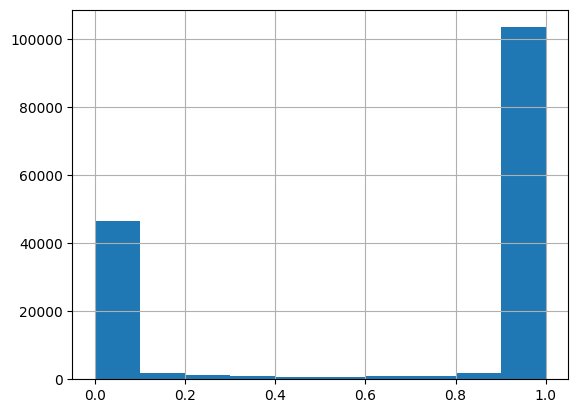

In [ ]:
train_df['gender'].hist()

In [ ]:
# # gender_binary: 성별 이진 분류
# #  - 0.5 이상이면 남성(1), 아니면 여성(0)으로 설정
# train_df['gender_binary'] = (train_df['gender'] >= 0.5).astype(int)

<br>

### 2.2.2 기본 파생 피처 생성

In [ ]:
def add_basic_features(df):
    # BMI
    df['BMI'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)
    new_features.append('BMI')

    # WHtR
    df['WHTR'] = df['waist_cm'] / df['height_cm']
    new_features.append('WHTR')

    # Pulse Pressure
    df['pulse_pressure'] = df['systolic'] - df['relaxation']
    new_features.append('pulse_pressure')

    # MAP
    df['MAP'] = df['relaxation'] + (df['systolic'] - df['relaxation']) / 3
    new_features.append('MAP')

    # LDL / Cholesterol 비율
    df['LDL_ratio'] = df['LDL'] / df['Cholesterol']
    new_features.append('LDL_ratio')

    return df

<br>

### 2.2.3 범주형 파생 피처 생성

In [ ]:
def add_categorical_features(df):
    # 혈압 등급
    df['BP_level'] = df.apply(
        lambda row: 4 if row['systolic'] >= 160 or row['relaxation'] >= 100 else
                    3 if 140 <= row['systolic'] <= 159 or 90 <= row['relaxation'] <= 99 else
                    2 if 130 <= row['systolic'] <= 139 or 80 <= row['relaxation'] <= 89 else
                    1 if 120 <= row['systolic'] <= 129 and row['relaxation'] < 80 else
                    0 if row['systolic'] < 120 and row['relaxation'] < 80 else
                    -1,
        axis=1
    )
    new_features.append('BP_level')

    # BP 카테고리
    df['BP_category'] = pd.cut(df['systolic'], bins=[0, 120, 130, 140, 180, np.inf], labels=[0, 1, 2, 3, 4]).astype('int')
    new_features.append('BP_category')

    # 콜레스테롤 관련
    df['total_cholesterol_risk'] = pd.cut(df['Cholesterol'], bins=[0, 200, 240, np.inf], labels=[0, 1, 2]).astype('int')
    df['HDL_risk'] = pd.cut(df['HDL'], bins=[0, 40, 60, np.inf], labels=[0, 1, 2]).astype('int')
    df['LDL_risk'] = pd.cut(df['LDL'], bins=[0, 100, 130, 160, 190, np.inf], labels=[0, 1, 2, 3, 4]).astype('int')
    new_features.extend(['total_cholesterol_risk', 'HDL_risk', 'LDL_risk'])

    # 나이 기반 위험군
    df['age_risk'] = (df['age'] >= 45).astype(int)
    new_features.append('age_risk')

    return df

<br>

### 2.2.4 상호작용 피처 생성

- 상호작용(Interaction) 피처 생성 함수

In [ ]:
def add_interaction_features(df):
    # BMI x AST
    df['BMI_AST'] = df['BMI'] * df['AST']
    new_features.append('BMI_AST')

    # 허리 x LDL
    df['waist_LDL'] = df['waist_cm'] * df['LDL']
    new_features.append('waist_LDL')

    # 헤모글로빈 기반 상호작용
    df['hemoglobin_sq'] = df['hemoglobin'] ** 2
    df['hemoglobin_x_height'] = df['hemoglobin'] * df['height_cm']
    df['hemoglobin_x_weight'] = df['hemoglobin'] * df['weight_kg']
    df['hemoglobin_x_Gtp'] = df['hemoglobin'] * df['Gtp']
    df['hemoglobin_x_creatinine'] = df['hemoglobin'] * df['serum_creatinine']
    df['weight_x_height'] = df['weight_kg'] * df['height_cm']

    new_features.extend([
        'hemoglobin_sq', 'hemoglobin_x_height', 'hemoglobin_x_weight',
        'hemoglobin_x_Gtp', 'hemoglobin_x_creatinine', 'weight_x_height'
    ])

    return df

In [ ]:
# 학습/테스트 데이터에 피처 적용
train_df = add_basic_features(train_df)
train_df = add_categorical_features(train_df)
train_df = add_interaction_features(train_df)

test_df = add_basic_features(test_df)
test_df = add_categorical_features(test_df)
test_df = add_interaction_features(test_df)

In [ ]:
new_features = list(dict.fromkeys(new_features))  # 순서 유지하며 중복 제거

<br>

### 2.2.5 다중공선성 확인

In [ ]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = train_df[new_features].copy()
X = add_constant(X)

vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 높은 순서로 확인
print(vif_df.sort_values(by='VIF', ascending=False))

                    feature          VIF
0                     const  5436.766665
17      hemoglobin_x_weight   433.675488
20          weight_x_height   364.339581
16      hemoglobin_x_height   327.654122
15            hemoglobin_sq   298.873624
2                       BMI    39.114841
14                waist_LDL    21.049689
11                 LDL_risk     7.681732
3                      WHTR     6.549041
8               BP_category     5.975132
5                       MAP     5.841318
6                 LDL_ratio     5.521324
1                    gender     5.213134
7                  BP_level     5.073153
9    total_cholesterol_risk     3.833529
19  hemoglobin_x_creatinine     2.725429
4            pulse_pressure     2.141343
13                  BMI_AST     1.604864
10                 HDL_risk     1.559441
18         hemoglobin_x_Gtp     1.525734
12                 age_risk     1.372722


In [ ]:
# new_features = []  # 필요 시 수행

<br>

## 2.3 피처 엔지니어링에 대한 시각화

### 2.3.1 Smoking과의 상관성 top10

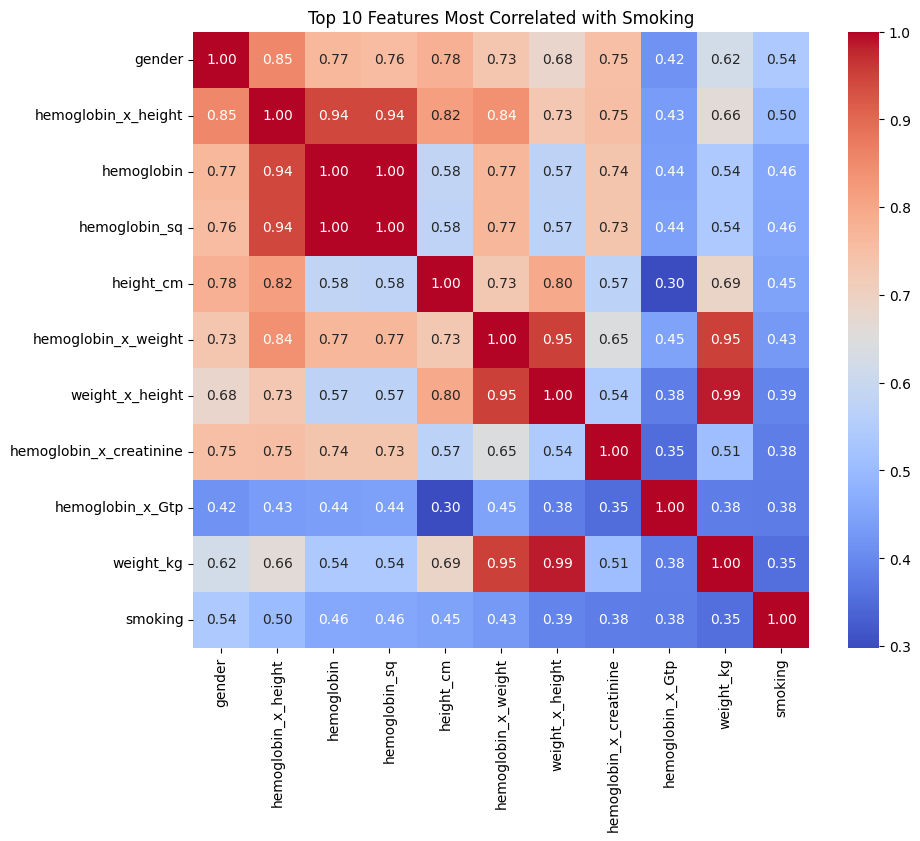

In [ ]:
# Smoking과의 상관계수 행렬 계산
# 수치형만 포함
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_df[numeric_cols].corr()

# smoking과의 상관계수만 추출
smoking_corr = corr_matrix['smoking'].drop('smoking') # 자기 자신 제외
top10_features = smoking_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# 4. 상위 10개 피처 + smoking 포함된 서브 상관 행렬
selected_corr = corr_matrix.loc[top10_features + ['smoking'], top10_features + ['smoking']]

# 5. 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Top 10 Features Most Correlated with Smoking')
plt.show()

In [ ]:
# 전체 상관계수 확인
print(smoking_corr.abs().sort_values(ascending=False))

gender                     0.537250
hemoglobin_x_height        0.503810
hemoglobin                 0.457492
hemoglobin_sq              0.456043
height_cm                  0.447762
hemoglobin_x_weight        0.428242
weight_x_height            0.389900
hemoglobin_x_creatinine    0.378082
hemoglobin_x_Gtp           0.377721
weight_kg                  0.353509
Gtp                        0.351160
triglyceride               0.334091
serum_creatinine           0.284294
HDL                        0.272626
waist_cm                   0.263878
HDL_risk                   0.243638
age                        0.205870
ALT                        0.197978
age_risk                   0.175738
eyesight_right             0.145542
BMI                        0.140303
eyesight_left              0.135579
relaxation                 0.108947
BMI_AST                    0.107454
dental_caries              0.106636
fasting_blood_sugar        0.102054
MAP                        0.093998
LDL_risk                   0

<br>

### 2.3.2 상관성 Top6 Pairplot

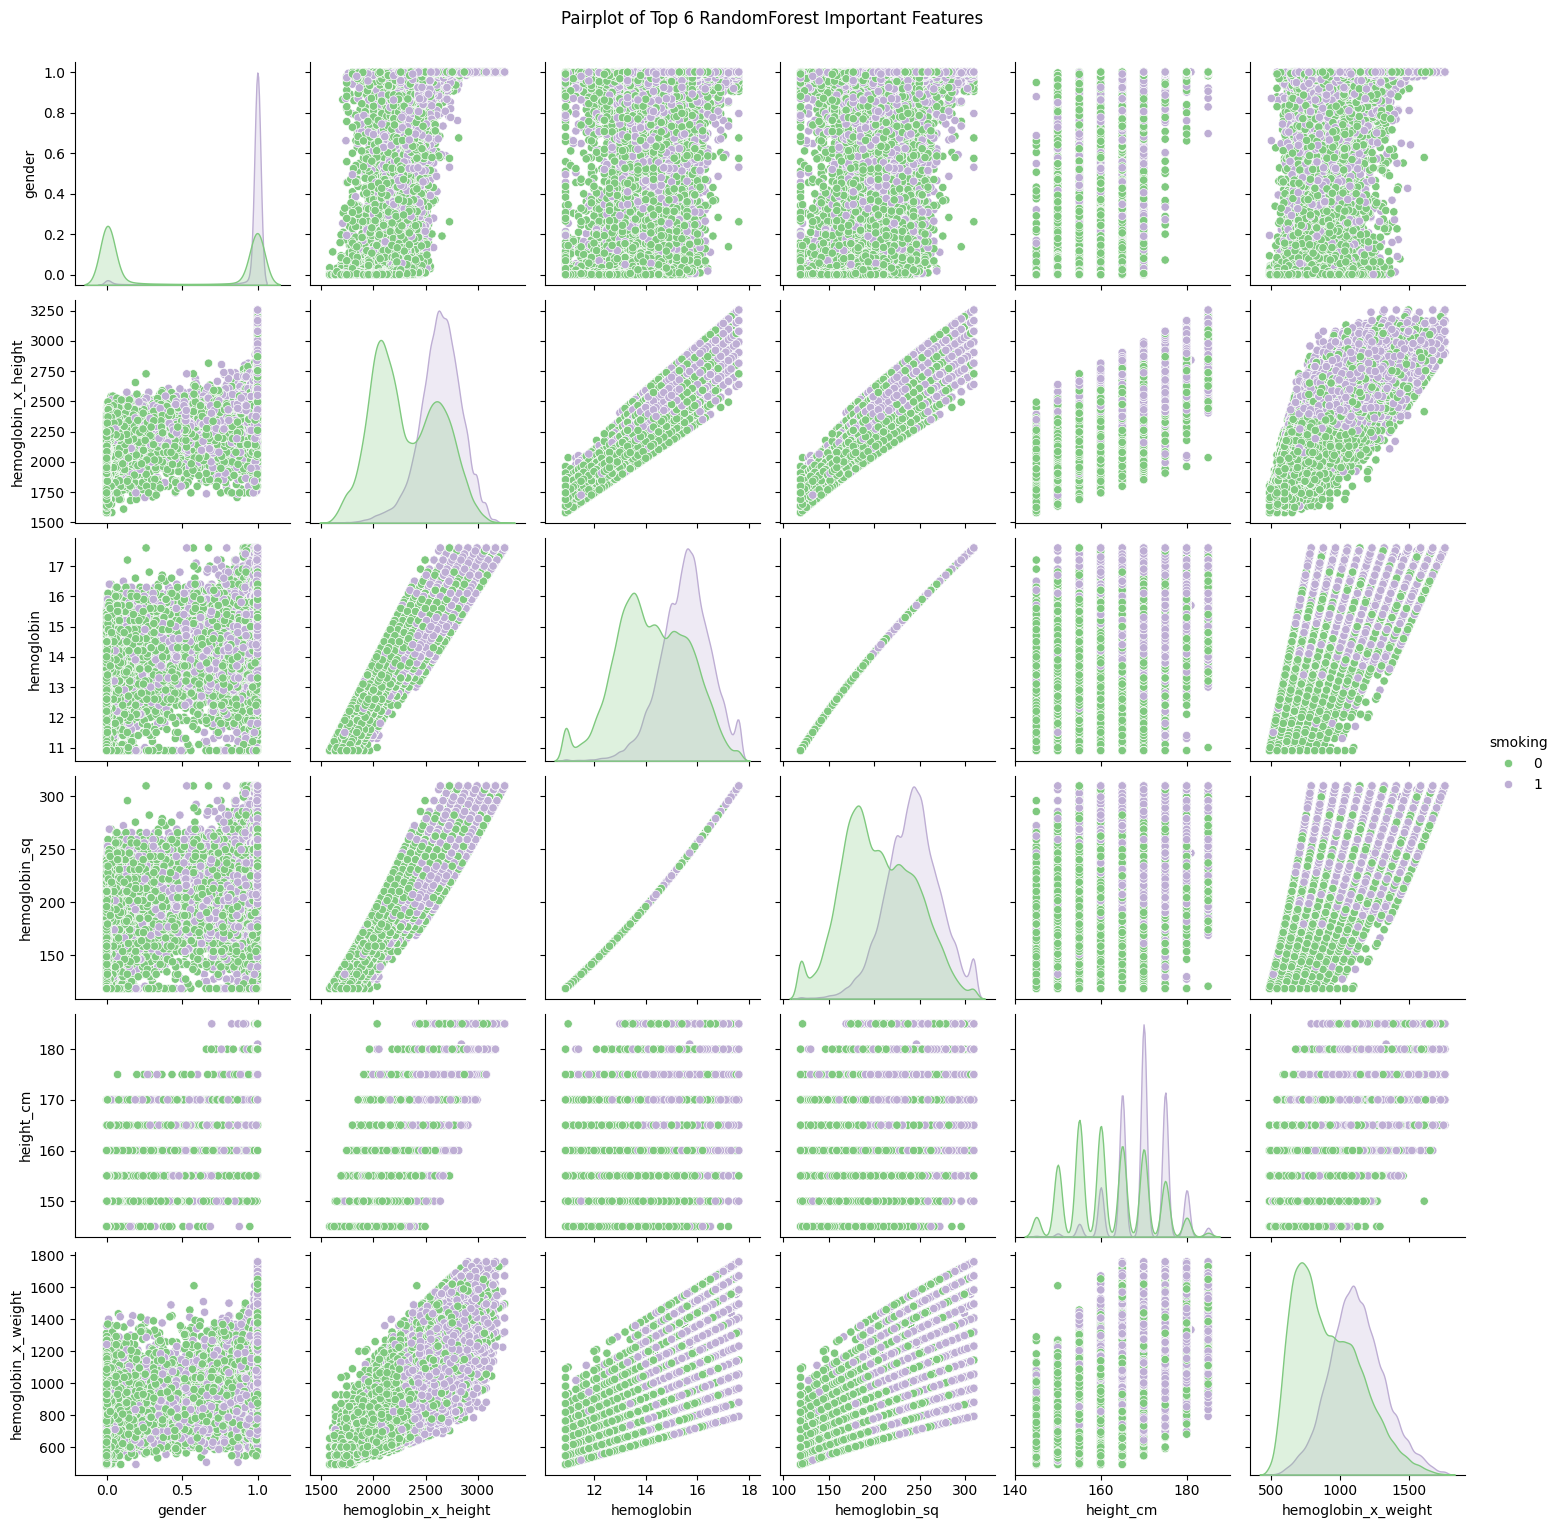

In [ ]:
# 상위 6개 Pairplot을 위한 데이터셋 구성
top6_features = smoking_corr.abs().sort_values(ascending=False).head(6).index.tolist()
pairplot_df = train_df[top6_features + ['smoking']]

# Pairplot 시각화
# 초록색이 0 / 보라색이 1
sns.pairplot(pairplot_df, hue='smoking', palette='Accent', diag_kind='kde')
plt.suptitle("Pairplot of Top 6 RandomForest Important Features", y=1.02)
plt.show()

**Feature 추가 이후 smoking과의 상관성 분석**  
  
  
| 순위	| 변수명 |	상관계수 | 해석 |
|------|-------|--------|-------|
| 1 |	gender |	0.54	| 성별에 따라 흡연 여부 큰 차이 존재. 남성일수록 흡연 비율 높음 |
| 2 |	hemoglobin × height	| 0.50 | 산소 운반능력 × 체격 → 흡연자의 생리적 보상 반응과 체형 반영 |
| 3 | hemoglobin_sq |	0.45 |	혈색소 비선형 효과 반영, 흡연 시 수치 증가 경향 |
| 4 | 	hemoglobin	| 0.45 | 	흡연자는 산소 부족 보상을 위해 혈색소 수치 상승 가능 |
| 5 |	height_cm	| 0.45 | 	성별 간 체형 차이 반영 가능, 흡연자에서 상대적으로 신장이 큰 경향 |
| 6	| hemoglobin × weight	| 0.43 |	체중과 혈색소의 결합 → 건강 상태 및 대사 요인 반영 가능성 |


<br>

### 2.3.3 New Features에 대한 Violinplot

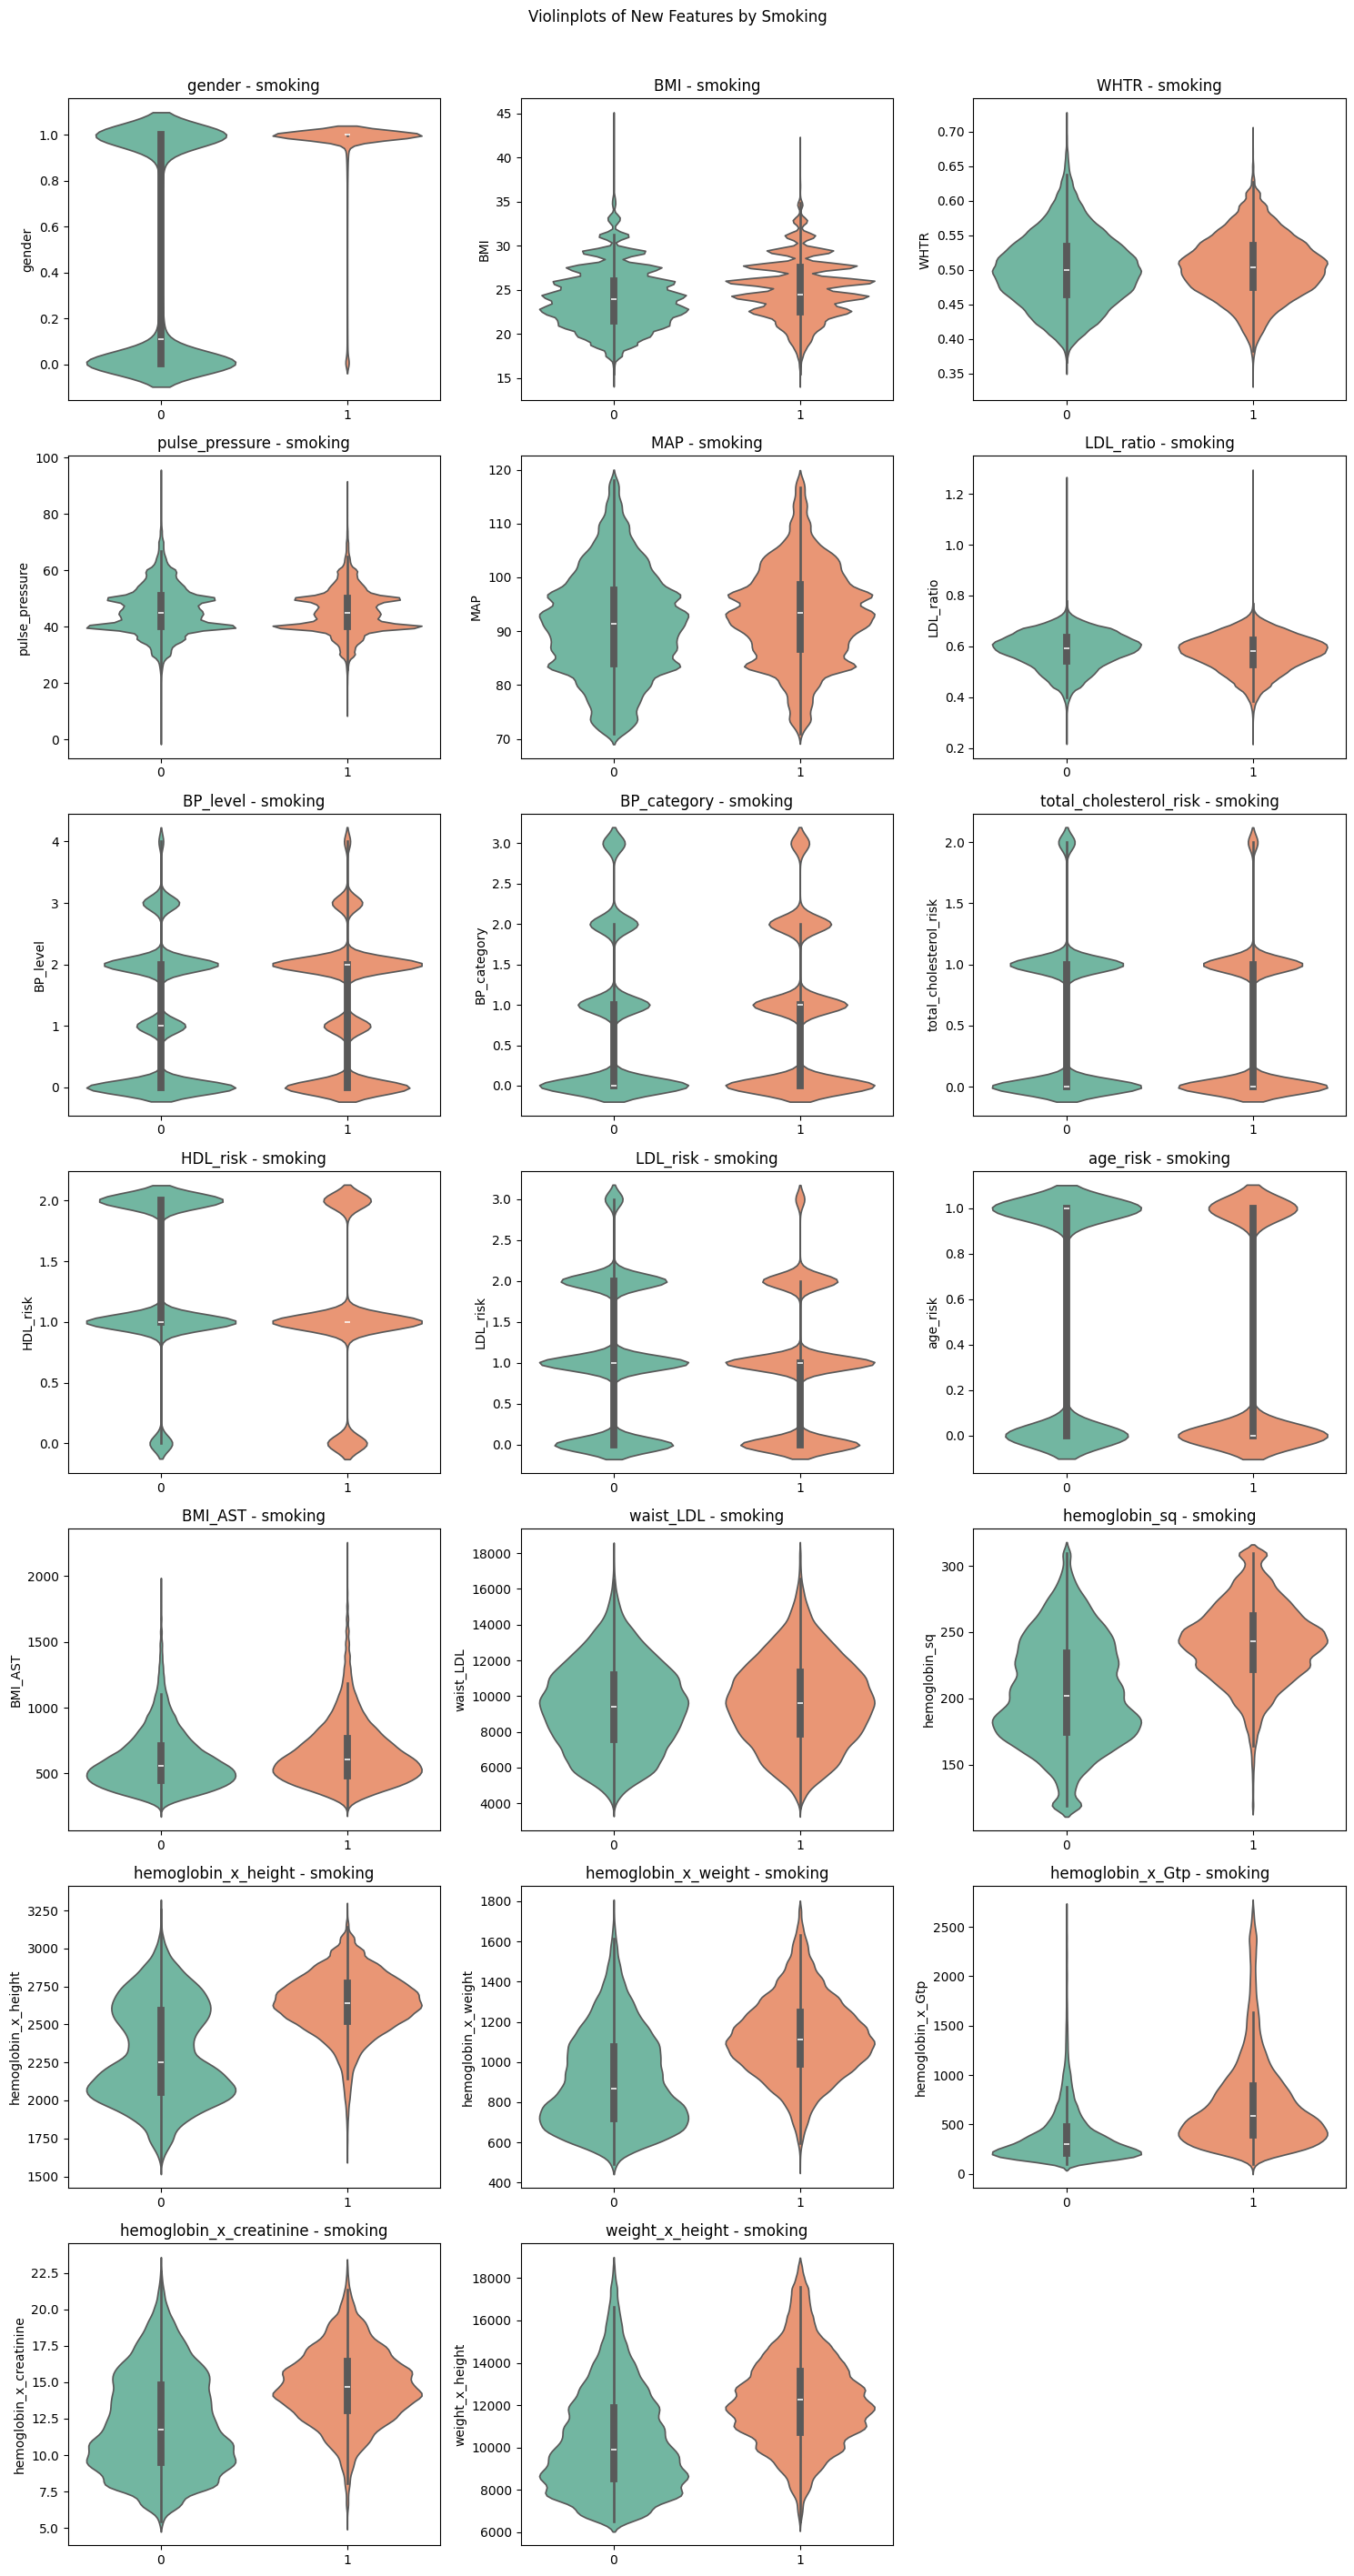

In [ ]:
## Violinplot - 추가된 피처들에 대한 시각화
# new_features = ['BMI', 'gender', 'BP_level', 'WHTR', 'pulse_pressure', 'MAP', 'LDL_ratio',
#                 'BP_category', 'total_cholesterol_risk', 'HDL_risk', 'LDL_risk', 'BMI_AST', 'waist_LDL', 'age_risk']
n_features = len(new_features)
n_cols = 3                                    # 열 개수: 한 행에 몇 개의 그래프 그릴지
n_rows = (n_features + n_cols -1) // n_cols   # 필요한 행 개수
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(new_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=train_df, x='smoking', y=col, palette='Set2', inner='box')
    plt.title(f'{col} - smoking')
    plt.xlabel('')
    plt.tight_layout()

plt.suptitle('Violinplots of New Features by Smoking', y=1.01)
plt.tight_layout()
plt.show()

**New Features
| 피처명                      | 해석                                                             |
| ------------------------ | -------------------------------------------------------------- |
| **gender**                 | 남성일수록 흡연 비율이 높음                                               |
| **BMI**                    | 흡연자가 비흡연자보다 BMI가 소폭 낮음                                        |
| **WHTR**                   | 흡연자는 허리둘레 대비 키 비율이 더 높음                                       |
| **pulse_pressure**         | 흡연자가 맥압(수축기-이완기)이 약간 더 큼                                      |
| **MAP**                    | 흡연자의 평균동맥압이 더 높게 분포함                                          |
| **LDL_ratio**              | 흡연자는 LDL/총콜레스테롤 비율이 약간 더 높음                                   |
| **BP_level**               | 흡연자는 고혈압 등급이 높은 쪽에 더 많이 분포                                    |
| **BP_category**            | 흡연자는 혈압 카테고리가 높은 그룹(3\~4)에 더 많음                               |
| **total_cholesterol_risk** | 흡연자는 고콜레스테롤 위험군에 더 많이 분포                                      |
| **HDL_risk**               | 흡연자는 HDL(좋은 콜레스테롤) 수치가 낮아 위험군 집중                              |
| **LDL_risk**               | 흡연자는 LDL 수치도 높아 위험도가 큼                                        |
| **age_risk**               | 흡연자 쪽에 45세 이상 고위험군 비율이 약간 더 많음                                |
| **BMI_AST**                | 흡연자의 BMI와 AST 곱 값이 더 높음                                       |
| **waist_LDL**              | 흡연자의 허리둘레 × LDL 값이 더 큼                                        |
| **hemoglobin_x_**         | 흡연자에서 헤모글로빈 관련 지표 전반적으로 더 큼. 흡연자의 산소 부족에 대한 생리적 보상 작용으로 해석 가능 |
| **weight_x_height**        | 흡연자는 체중 × 키 값도 평균적으로 더 큼                                      |



<br>
<br>

# 3. 데이터 분리 및 전처리

## 3.1 학습/검증 데이터 분리(train/test split)

- train/test 데이터 분리 함수

In [ ]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df):
    """
    이진 분류용 데이터셋에서 feature/target 분리 후,
    학습용/검증용 데이터로 분할하는 함수

    Parameters
    ----------
    df : pd.DataFrame
        전처리 완료된 학습용 데이터프레임 (smoking 포함)

    Returns
    -------
    X_train : pd.DataFrame
        학습용 feature 데이터
    X_test : pd.DataFrame
        테스트용 feature 데이터 (성능 평가용)
    y_train : pd.Series
        학습용 타겟 값
    y_test : pd.Series
        테스트용 타겟 값
    """

    df_copy = df.copy()

    # feature/target 분리
    X_features = df_copy.drop(columns=['id', 'smoking'])  # id도 drop
    y_target = df_copy['smoking']

    # stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target,
        test_size=0.2,
        random_state=SEED,
        stratify=y_target
    )

    return X_train, X_test, y_train, y_test

- train/test 데이터 분리

In [ ]:
# 데이터 전처리 후, feature/label 분리 후 train/test 셋 분리
X_train, X_test, y_train, y_test = get_train_test_dataset(train_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print()
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)
print()
print('원본 전체 데이터 비율')
print(train_df['smoking'].value_counts(normalize=True) * 100)

학습 데이터 레이블 값 비율
smoking
0    56.26354
1    43.73646
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
smoking
0    56.263343
1    43.736657
Name: count, dtype: float64

원본 전체 데이터 비율
smoking
0    56.2635
1    43.7365
Name: proportion, dtype: float64


<br>

## 3.2 전처리

- 결측값 처리  
- 인코딩 (LabelEncoder, OneHotEncoder 등)  
- 스케일링 (StandardScaler, MinMaxScaler 등)  
- 파이프라인(Pipeline) 구성 (추천)  

<br>
<br>

# 4. 모델 학습 및 평가

## 4.1 평가 함수 정의


- 평가 지표 출력 함수

In [ ]:
# 성능 저장 리스트
model_score = []

In [ ]:
def get_clf_eval(y_test, pred, pred_proba=None, model_name=None):
    """
    이진 분류 모델의 주요 성능 지표를 출력하는 평가 함수

    Parameters
    ----------
    y_test : array-like
        실제 레이블 값 (정답)
    pred : array-like
        분류 모델의 예측 결과 (0 또는 1)
    pred_proba : array-like, optional
        클래스 1에 대한 예측 확률 (ROC-AUC 계산용)

    Returns
    -------
    None
        평가 지표를 출력만 하고 반환값은 없음

    출력 내용
    -------
    - 오차 행렬 (Confusion Matrix)
    - 정확도 (Accuracy)
    - 정밀도 (Precision)
    - 재현율 (Recall)
    - F1 스코어
    - ROC-AUC (클래스 1의 예측 확률 기반)
    """

    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba) if pred_proba is not None else None

    print(f'{model_name} 결과')
    print('Confusion Matrix:')
    print(confusion)
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    if roc_auc is not None:
        print(f'ROC-AUC: {roc_auc:.4f}')

    # 결과 저장
    model_score.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4),
        'ROC-AUC': round(roc_auc, 4) if roc_auc is not None else None
    })

- 모델 학습 및 평가 함수

In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

def get_model_train_eval(model, model_name, ftr_train, ftr_test, tgt_train, tgt_test):
    """
    모델 학습 및 평가 수행 함수
    - LightGBM, XGBoost는 early stopping 자동 적용

    Parameters
    ----------
    model : classifier model object
        학습 및 예측에 사용할 분류 모델 객체
    ftr_train : array-like
        학습용 feature 데이터
    ftr_test : array-like
        테스트용 feature 데이터
    tgt_train : array-like
        학습용 target 값
    tgt_test : array-like
        테스트용 target 값

    Returns
    -------
    없음 (내부에서 평가 결과를 출력함)
    """

    eval_set = [(ftr_train, tgt_train), (ftr_test, tgt_test)]

    if isinstance(model, LGBMClassifier):
        model.fit(ftr_train, tgt_train,
                  eval_set=eval_set,
                  eval_metric='auc',
                  callbacks=[early_stopping(100, verbose=False), log_evaluation(period=0)])
    elif isinstance(model, XGBClassifier):
        model.fit(ftr_train, tgt_train,
                  eval_set=eval_set,
                  verbose=False)
    else:
        model.fit(ftr_train, tgt_train)

    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba, model_name=model_name)

<br>

## 4.2 베이스라인 모델 학습

머신러닝 분류기의 성능을 비교하기 위해 총 7개의 대표적인 모델을 동일한 전처리 및 기본 설정 하에 학습시켜 보았다.

- 주요 비교 기준: Accuracy, Precision, Recall, F1-score, ROC-AUC
- Confusion Matrix를 통해 각 클래스에 대한 분류 성능도 함께 검토

<br>

**모델 선정 배경 및 기대효과**

- Tree 계열 모델 (LightGBM, XGBoost, CatBoost)
    - Gradient Boosting 기반의 트리 모델들은 범주형, 연속형 변수가 혼재된 이진 분류 문제에 강점을 갖는다. 특히 대회 데이터셋의 경우 다양한 생체 신호 변수 간 비선형적 상호작용이 존재할 것으로 판단되어 복잡한 의사결정을 잘 포착할 수 있는 모델로 기대되었다.

- Logistic Regression
    - 선형모델로서 해석력이 뛰어나고, 비교 기준이 되는 baseline으로 적합하다. 실제로 recall이 높은 편이며, 단순 모델임에도 불구하고 좋은 F1 점수를 기록하였다.

- RandomForest / AdaBoost
    - 다소 구형의 모델이지만 빠른 학습 속도와 직관적인 구조로 baseline 단계에서는 유용하다. 다양한 feature 간의 관계 파악 가능성과 함께 모델의 안정성을 평가하는 데 도움을 주었다.

- KNN / DecisionTree
    - 비교적 단순한 구조로, 데이터 구조에 대한 감을 얻기 위한 참고용으로 실험에 포함하였다.


<br>


- 모델 객체 생성

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

log_clf = LogisticRegression(max_iter=1000)  # 수렴 실패 방지

lgbm_clf = LGBMClassifier(boost_from_average=False,  # 불균형 데이터이므로 모델 자체 학습 유도
                          # force_row_wise=True,     # 멀티스레딩 경고 로그 제거
                          random_state=SEED,
                          n_jobs=-1,
                          verbosity=-1
                         )

xgb_clf = XGBClassifier(eval_metric='auc',
                        early_stopping_rounds=10,
                        use_label_encoder=False,
                        random_state=SEED,
                        n_jobs=-1
                       )

cat_clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    verbose=0,
    random_seed=42
)

rf_clf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
dt_clf = DecisionTreeClassifier(random_state=SEED)
knn_clf  = KNeighborsClassifier()
ada_clf = AdaBoostClassifier(random_state=SEED)

<br>

- LogisticRegression

In [ ]:
# LogisticRegression
get_model_train_eval(model=log_clf,
                     model_name='LogisticRegression',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

LogisticRegression 결과
Confusion Matrix:
[[13576  4345]
 [ 3843 10088]]
Accuracy: 0.7429, Precision: 0.6990, Recall: 0.7241, F1: 0.7113
ROC-AUC: 0.8313


- LightGBM

In [ ]:
# LightGBM
get_model_train_eval(model=lgbm_clf,
                     model_name='LightGBM',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

LightGBM 결과
Confusion Matrix:
[[13487  4434]
 [ 2613 11318]]
Accuracy: 0.7788, Precision: 0.7185, Recall: 0.8124, F1: 0.7626
ROC-AUC: 0.8640


- XGBoost

In [ ]:
# XGBoost
get_model_train_eval(model=xgb_clf,
                     model_name='XGBoost',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

XGBoost 결과
Confusion Matrix:
[[13504  4417]
 [ 2638 11293]]
Accuracy: 0.7785, Precision: 0.7188, Recall: 0.8106, F1: 0.7620
ROC-AUC: 0.8633


- RandomForest

In [ ]:
# RandomForest
get_model_train_eval(model=rf_clf,
                     model_name='RandomForest',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

RandomForest 결과
Confusion Matrix:
[[13405  4516]
 [ 2693 11238]]
Accuracy: 0.7737, Precision: 0.7133, Recall: 0.8067, F1: 0.7572
ROC-AUC: 0.8549


- DecisionTree

In [ ]:
# DecisionTree
get_model_train_eval(model = dt_clf,
                     model_name='DecisionTree',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

DecisionTree 결과
Confusion Matrix:
[[13069  4852]
 [ 4891  9040]]
Accuracy: 0.6941, Precision: 0.6507, Recall: 0.6489, F1: 0.6498
ROC-AUC: 0.6891


- KNN

In [ ]:
# KNN
get_model_train_eval(model = knn_clf,
                     model_name='KNN',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

KNN 결과
Confusion Matrix:
[[12984  4937]
 [ 3991  9940]]
Accuracy: 0.7197, Precision: 0.6681, Recall: 0.7135, F1: 0.6901
ROC-AUC: 0.7883


- AdaBoost

In [ ]:
# AdaBoost
get_model_train_eval(model = ada_clf,
                     model_name='AdaBoost',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

AdaBoost 결과
Confusion Matrix:
[[13015  4906]
 [ 2516 11415]]
Accuracy: 0.7670, Precision: 0.6994, Recall: 0.8194, F1: 0.7547
ROC-AUC: 0.8480


- CatBoost

In [ ]:
get_model_train_eval(model=cat_clf,
                     model_name='CatBoost',
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                     )

CatBoost 결과
Confusion Matrix:
[[13474  4447]
 [ 2541 11390]]
Accuracy: 0.7806, Precision: 0.7192, Recall: 0.8176, F1: 0.7653
ROC-AUC: 0.8656


<br>

- Baseline 모델 성능 비교
    - 하이퍼파라미터 튜닝 전 모델 초기 성능 평가
    - 이후 하이퍼파라미터 튜닝 시 기준선으로 활용

In [ ]:
model_score_df = pd.DataFrame(model_score)
model_score_df

Model  Accuracy  Precision  Recall      F1  ROC-AUC
0  LogisticRegression    0.7429     0.6990  0.7241  0.7113   0.8313
1            LightGBM    0.7788     0.7185  0.8124  0.7626   0.8640
2             XGBoost    0.7785     0.7188  0.8106  0.7620   0.8633
3        RandomForest    0.7737     0.7133  0.8067  0.7572   0.8549
4        DecisionTree    0.6941     0.6507  0.6489  0.6498   0.6891
5                 KNN    0.7197     0.6681  0.7135  0.6901   0.7883
6            AdaBoost    0.7670     0.6994  0.8194  0.7547   0.8480
7            CatBoost    0.7806     0.7192  0.8176  0.7653   0.8656

In [ ]:
model_sorted_df = model_score_df.sort_values(
    by=['ROC-AUC', 'Recall', 'Precision', 'F1'],
    ascending=False
)
model_sorted_df

Model  Accuracy  Precision  Recall      F1  ROC-AUC
7            CatBoost    0.7806     0.7192  0.8176  0.7653   0.8656
1            LightGBM    0.7788     0.7185  0.8124  0.7626   0.8640
2             XGBoost    0.7785     0.7188  0.8106  0.7620   0.8633
3        RandomForest    0.7737     0.7133  0.8067  0.7572   0.8549
6            AdaBoost    0.7670     0.6994  0.8194  0.7547   0.8480
0  LogisticRegression    0.7429     0.6990  0.7241  0.7113   0.8313
5                 KNN    0.7197     0.6681  0.7135  0.6901   0.7883
4        DecisionTree    0.6941     0.6507  0.6489  0.6498   0.6891

예상대로 Gradient Boosting 기반 모델들이 전반적으로 높은 성능을 기록하였다. 특히 CatBoost는 모든 평가지표에서 상위권을 기록하였으며, LightGBM과 XGBoost 역시 ROC-AUC 0.86 이상을 기록하며 안정적인 예측력을 보였다. 반면, DecisionTree나 KNN은 단일모델 특성상 성능이 비교적 낮았고, 실제로 Recall과 ROC-AUC가 모두 떨어졌다.

Logistic Regression은 선형 모델임에도 불구하고 Recall 0.81, ROC-AUC 0.84 수준의 견고한 성능을 보였으며, baseline의 기준으로서 좋은 출발점을 제공하였다. (말투 수정 필요)



In [ ]:
# # 모델 성능 결과 초기화 - 필요 시 실행
# model_score.clear()
# model_score_df = pd.DataFrame(model_score)
# model_sorted_df = pd.DataFrame(model_score)

<br>

## 4.3 중요 변수 선별 (SHAP)

100%|===================| 127333/127404 [14:20<00:00]       

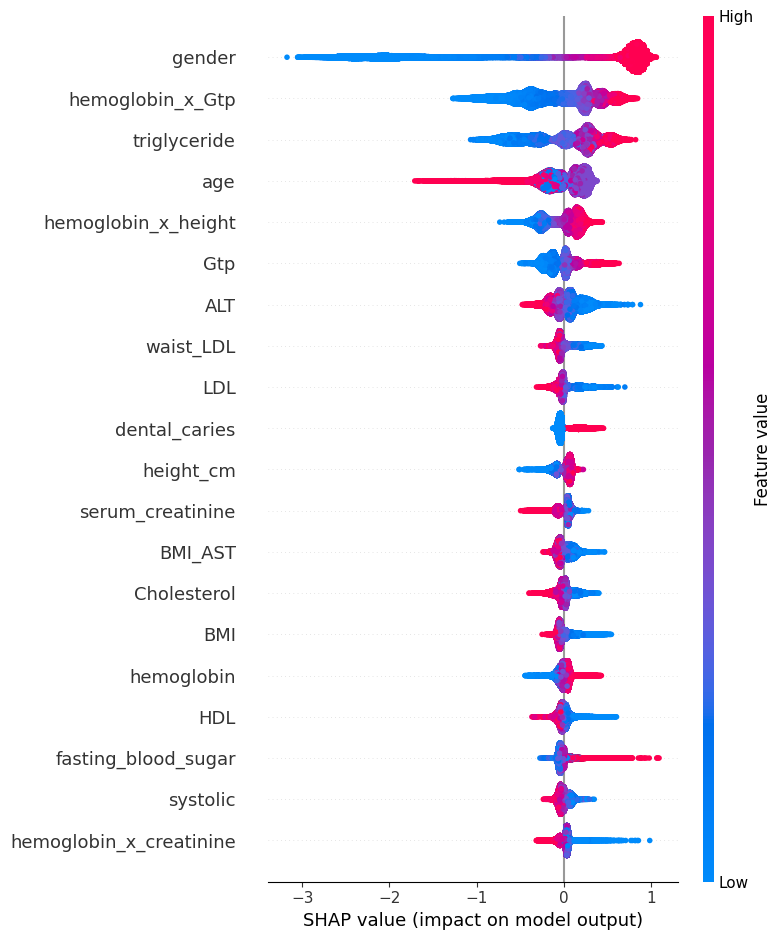

In [ ]:
# LightGBM explainer
explainer_lgbm = shap.Explainer(lgbm_clf, X_train)  # 또는 TreeExplainer 사용 가능
shap_values_lgbm = explainer_lgbm(X_train, check_additivity=False)  # 13분 소요

# Summary plot for LightGBM
shap.summary_plot(shap_values_lgbm, X_train, show=True)

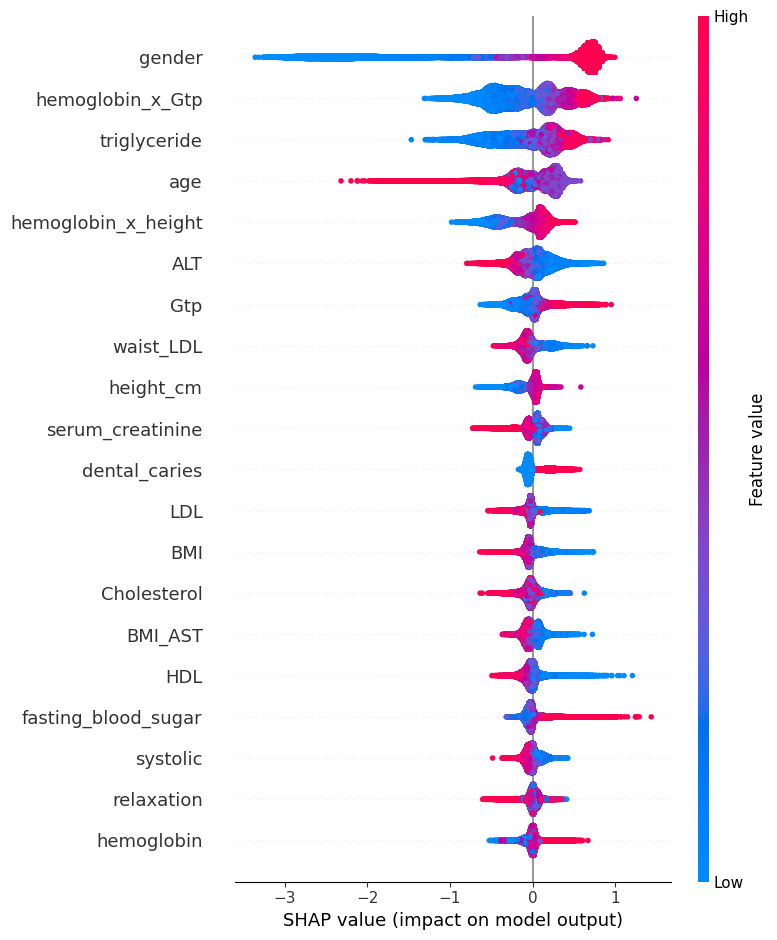

In [ ]:
# XGBoost explainer
explainer_xgb = shap.Explainer(xgb_clf)  # best_xgb_model은 학습된 XGBoost 모델
shap_values_xgb = explainer_xgb(X_train) # 2분 소요

# Summary plot for XGBoost
shap.summary_plot(shap_values_xgb, X_train, show=True)

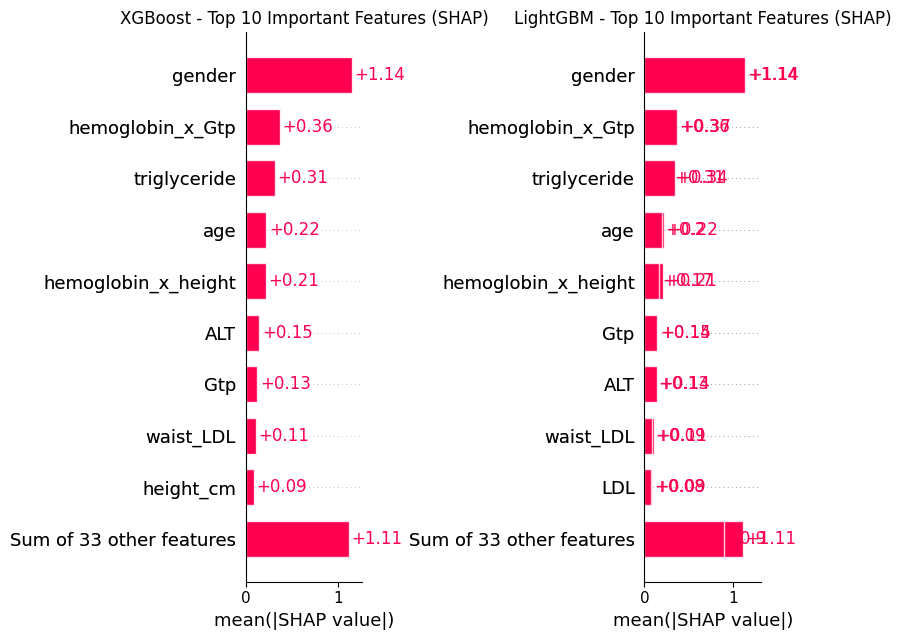

In [ ]:
## 두 모델의 중요 변수 비교 (Bar Plot 버전)

import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'  # or 'DejaVu Sans', 'NanumGothic', 'Malgun Gothic' (한글 포함시)

# 서브플롯 설정 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# XGBoost bar plot
shap.plots.bar(shap_values_xgb, max_display=10, show=False)
axes[0].set_title('XGBoost - Top 10 Important Features (SHAP)')
plt.sca(axes[0])  # 현재 axes 지정
shap.plots.bar(shap_values_xgb, max_display=10, show=False)

# LightGBM bar plot
plt.sca(axes[1])  # 오른쪽 subplot에 출력
shap.plots.bar(shap_values_lgbm, max_display=10, show=False)
axes[1].set_title('LightGBM - Top 10 Important Features (SHAP)')

plt.tight_layout()
plt.show()

<br>

## 4.4 Feature Selection

VIF가 100 이상인 피처

- hemoglobin_x_weight, weight_x_height, hemoglobin_x_height, hemoglobin_sq 등 상호작용 파생변수 → 중복/유사 정보 가능성

상관계수가 0.1 이하인 피처

- BP_category, pulse_pressure, urine_protein, hearing_left/right, WHTR, waist_LDL, Cholesterol, total_cholesterol_risk, systolic, AST 등 → 제거 후보


| 기준                        | 설명                      | 제거 기준     |
| ------------------------- | ----------------------- | --------- |
| **VIF (다중공선성)**        | 100 이상 → 강한 다중공선성 우려     | **제거**    |
| **타겟 상관계수**            | 0.1 미만 → 타겟 예측에 기여도 낮음  | **제거** |
| **Feature Importance** | 0.01 미만 → RandomForest 모델 내 기여 거의 없음 | **제거** |



In [ ]:
# 랜덤포레스트를 통한 Feature Importance 확인
# from sklearn.ensemble import RandomForestClassifier

# # 1. 데이터 준비
# X = train_df.drop(columns=['smoking'])
# y = train_df['smoking']

# # 2. 모델 훈련
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train, y_train)  # 셀 위치가 이동 -> 전체가 아닌 X_train, y_train 학습으로 수정

# # 3. Feature Importance 추출
# importances = pd.Series(rf.feature_importances_, index=X.columns)
# print(importances.sort_values(ascending=False))

In [ ]:
# Feature Importance ≤ 0.01 피처 목록
low_importance = [
    'serum_creatinine', 'eyesight_left', 'eyesight_right',
    'weight_kg', 'BP_level', 'HDL_risk', 'BP_category',
    'dental_caries', 'LDL_risk', 'age_risk',
    'total_cholesterol_risk', 'urine_protein',
    'hearing_right', 'hearing_left'
]

# VIF ≥ 100 또는 중복 특성
high_vif = [
    'hemoglobin_x_weight', 'weight_x_height',
    'hemoglobin_x_height', 'hemoglobin_sq'
]

# 최종 제거 리스트
drop_features = list(set(low_importance + high_vif))

In [ ]:
# drop 후보 컬럼 제거
train_df.drop(columns=drop_features, inplace=True)
test_df.drop(columns=drop_features, inplace=True)

# new_features 리스트도 업데이트
new_features = [f for f in new_features if f not in drop_features]

- 다중공선성 문제를 방지하기 위해 VIF(Variance Inflation Factor)가 10 이상인 변수는 제거 후보로 선정하였다.
- 또한, 타겟(smoking)과의 Pearson 상관계수가 0.1 미만인 변수는 예측에 유의미한 영향을 주기 어렵다고 판단하여 제외하였다.
- 최종적으로 상호작용 항 중 유사 정보가 중복되는 항목들과 생리적 의미가 약한 항목을 제거하여 일반화 성능을 향상시키고 모델의 해석력을 높이고자 하였다.

In [ ]:
# 선택된 피처로 다중공선성 확인

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = train_df[new_features].copy()
X = add_constant(X)

vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 확인
print(vif_df.sort_values(by='VIF', ascending=False))

                    feature         VIF
0                     const  363.443901
8                 waist_LDL    3.978483
2                       BMI    3.329759
3                      WHTR    3.319124
6                 LDL_ratio    2.990380
1                    gender    2.512044
10  hemoglobin_x_creatinine    2.350008
7                   BMI_AST    1.578653
9          hemoglobin_x_Gtp    1.480812
5                       MAP    1.281481
4            pulse_pressure    1.163700


**피처 엔지니어링 시도 및 최종 성능 영향 분석**

모델 성능 향상을 위해 다양한 도메인 기반 피처를 추가 생성하였다.

생성된 피처는 다음 세 가지 범주로 구분할 수 있었다.

- 기본 파생 피처: BMI, WHtR, Pulse Pressure, LDL/Cholesterol 비율 등 기본적인 건강 지표 기반 계산식

- 카테고리형 파생 피처: 혈압·콜레스테롤·연령 구간을 활용한 위험도 구간화 및 이산화

- 상호작용 피처: BMI×AST, 허리×LDL, 헤모글로빈×여러 생체지표 등 변수 간 비선형 조합

총 20여 개 이상의 파생 피처를 적용하였고, VIF(다중공선성 지표) 및 Feature Importance 기준의 Feature Selection도 병행하였다. 그러나 이와 같은 시도는 기대와 달리 모델 성능을 의미 있게 향상시키지 못했으며, 오히려 일부 조합에서는 성능이 감소하는 현상이 관측되었다.

- Gender만 추가했을 때 private score: 0.87382
- 여러 피처를 추가한 후의 private score: 0.87194
    - Feature Selection까지 적용한 경우의 private score 더 하락

이러한 결과는 피처 엔지니어링 과정에서 유의미하다고 판단된 변수들이 실제 예측력 개선에 기여하지 못했음을 의미한다.

이는 다음과 같은 해석이 가능하다.

- 추가 파생 피처들이 기존 변수에서 이미 암묵적으로 포착된 정보를 중복해서 표현했을 가능성

- 특정 변수 간 상호작용이 이론적으로 유효하더라도 실제 예측 모델에서는 잡음(noise)으로 작용했을 가능성

- 데이터 분포 또는 학습 구조에 따라 모델이 이러한 복잡한 변형을 효과적으로 활용하지 못했을 가능성

>결과적으로, 가장 단순하고 직관적인 변수인 ‘Gender’ 하나의 추가만이 성능 향상에 유의미하게 기여한 것으로 판단된다.
>
>이는 오히려 복잡한 피처 엔지니어링이 항상 예측 성능 향상으로 이어지는 것은 아니라는 중요한 시사점을 제공한다. 모델과 데이터 구조에 적합한 최소한의 정보 제공이 오히려 더 강력한 결과로 연결될 수 있음을 보여준다.

<br>

## 4.5 하이퍼파라미터 튜닝
- GridSearchCV, RandomizedSearch CV 등

- early stopping 파라미터 반환 함수

    - 하이퍼파라미터 튜닝 중인 모델이 XGBoost 또는 LightGBM일 경우, 조기 종료(early stopping)와 평가 지표(log evaluation)를 위한 추가 학습 인자(fit_params)를 자동으로 설정해 준다.

In [ ]:
from lightgbm import early_stopping, log_evaluation

def get_fit_params_with_early_stopping(model, X_train, X_test, y_train, y_test):
    """
    GridSearchCV/RandomizedSearchCV의 fit() 호출 시 사용할 fit_params 반환

    Parameters
    ----------
    model : 학습 대상 모델 객체
    X_train, X_test, y_train, y_test : 학습/평가 데이터

    Returns
    -------
    fit_params : dict
        모델 학습 시 fit()에 전달할 파라미터
    """

    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMClassifier):
        return {
            'eval_set': eval_set,
            'eval_metric': 'auc',
            'callbacks': [
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        }

    elif isinstance(model, XGBClassifier):
        return {
            'eval_set': eval_set,
            'verbose': False
        }

    elif isinstance(model, CatBoostClassifier):
        return {
            'eval_set': eval_set,
            'early_stopping_rounds': 100,
            'verbose': False
        }

    else:
        # 일반 모델은 fit_params 없이 return
        return {}

- 튜닝된 최적 모델 평가 함수

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_best_model(grid_cv, X_test, y_test):
    """
    GridSearchCV/RandomizedSearchCV로 튜닝된 최적 모델을 테스트 세트에 대해 평가하는 함수

    Parameters
    ----------
    grid_cv : GridSearchCV 또는 RandomizedSearchCV 객체 (fit 완료된 상태)
    X_test : 테스트 피처
    y_test : 테스트 타겟

    Prints
    ------
    - 최적 하이퍼파라미터
    - 교차 검증 기반 Best F1 score
    - 테스트 ROC-AUC
    - 테스트 데이터의 classification_report: precision, recall, f1-score, support
    """

    print('Best Hyperparameters:', grid_cv.best_params_)
    print('Best F1 Score:', grid_cv.best_score_)

    best_model = grid_cv.best_estimator_
    pred = best_model.predict(X_test)
    pred_proba = best_model.predict_proba(X_test)[:, 1]

    print('Test ROC-AUC:', roc_auc_score(y_test, pred_proba))
    print(classification_report(y_test, pred))

    return best_model

<br>

- GridSearch: LightGBM

In [ ]:
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, roc_auc_score

# # 튜닝 대상 파라미터
# lgbm_params = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     # 'num_leaves': [31, 64],
#     }

# # 모델 정의
# lgbm_clf = LGBMClassifier(boost_from_average=False,
#                           random_state=42,
#                           n_jobs=-1,
#                           verbosity=-1
#                          )

# # 조기 종료용 fit_params
# fit_params = get_fit_params_with_early_stopping(lgbm_clf, X_train, X_test, y_train, y_test)

# # GridSearchCV 정의
# grid_cv_lgbm = GridSearchCV(lgbm_clf, lgbm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# # 학습 시 추가 fit_params 전달
# grid_cv_lgbm.fit(X_train, y_train, **fit_params)

# # 최적 모델로 예측 및 평가
# best_lgbm_grid = evaluate_best_model(grid_cv_lgbm, X_test, y_test)

- GridSearch: XGBoost

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, roc_auc_score

# # 튜닝 대상 파라미터
# xgb_params = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

# # 모델 정의
# xgb_clf = XGBClassifier(eval_metric='auc',
#                         early_stopping_rounds=10,
#                         use_label_encoder=False,
#                         random_state=42,
#                         n_jobs=-1
#                        )

# # 조기 종료용 fit_params
# fit_params = get_fit_params_with_early_stopping(xgb_clf, X_train, X_test, y_train, y_test)

# # GridSearchCV 정의
# grid_cv_xgb = GridSearchCV(xgb_clf, xgb_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# # 학습 시 추가 fit_params 전달
# grid_cv_xgb.fit(X_train, y_train, **fit_params)

# # 최적 모델로 예측 및 평가
# best_xgb_grid = evaluate_best_model(grid_cv_xgb, X_test, y_test)

<br>

- RandomSearch: LightGBM

In [ ]:
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import classification_report, roc_auc_score

# # 튜닝 대상 파라미터
# lgbm_param_dist = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7, -1],
#     'num_leaves': [31, 64, 128],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }

# # 모델 정의
# lgbm_clf = LGBMClassifier(boost_from_average=False, random_state=42, n_jobs=-1, verbosity=-1)

# # 조기 종료용 fit_params
# fit_params = get_fit_params_with_early_stopping(lgbm_clf, X_train, X_test, y_train, y_test)

# # RandomizedSearchCV 정의
# rand_cv_lgbm = RandomizedSearchCV(
#     estimator=lgbm_clf,
#     param_distributions=lgbm_param_dist,
#     n_iter=20,
#     scoring='f1',
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )

# # 학습 시 추가 fit_params 전달
# rand_cv_lgbm.fit(X_train, y_train, **fit_params)

# # 최적 모델로 예측 및 평가
# best_lgbm_rand = evaluate_best_model(rand_cv_lgbm, X_test, y_test)

- RandomSearch: XGBoost

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import classification_report, roc_auc_score

# # 튜닝 대상 파라미터
# xgb_param_dist = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3, 1]
# }

# # 모델 정의
# xgb_clf = XGBClassifier(use_label_encoder=False, random_state=42, n_jobs=-1)

# # 조기 종료용 fit_params
# fit_params = get_fit_params_with_early_stopping(xgb_clf, X_train, X_test, y_train, y_test)

# # RandomizedSearchCV 정의
# rand_cv_xgb = RandomizedSearchCV(
#     estimator=xgb_clf,
#     param_distributions=xgb_param_dist,
#     n_iter=20,
#     scoring='f1',
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )

# # 학습 시 추가 fit_params 전달
# rand_cv_xgb.fit(X_train, y_train, **fit_params)

# # 최적 모델로 예측 및 평가
# best_xgb_rand = evaluate_best_model(rand_cv_xgb, X_test, y_test)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 결과 저장 리스트
voting_model_score = []

# 이진 분류 평가 함수
def get_clf_eval(y_test, pred, pred_proba=None, model_name=None, best_params=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba) if pred_proba is not None else None

    print(f'{model_name} 결과')
    print('Confusion Matrix:')
    print(confusion)
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    if roc_auc is not None:
        print(f'ROC-AUC: {roc_auc:.4f}')

    voting_model_score.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4),
        'ROC-AUC': round(roc_auc, 4) if roc_auc is not None else None,
        'Best Params': best_params
    })

# ------------------------
# 공통 CV 전략
# ------------------------
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=6)

# ------------------------
# LightGBM 튜닝
# ------------------------
lgbm = LGBMClassifier(random_state=6, n_jobs=-1)
lgbm_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 10, 15],
    'n_estimators': [500, 1000, 1500],
    'min_child_samples': [10, 30, 50]
}
lgbm_search = RandomizedSearchCV(lgbm, lgbm_params, scoring='roc_auc', n_iter=10, cv=cv_strategy, random_state=6)
lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_
print('Best LGBM params:', lgbm_search.best_params_)

# ------------------------
# XGBoost 튜닝
# ------------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=6, n_jobs=-1)
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 10, 15],
    'n_estimators': [500, 1000, 1500],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb, xgb_params, scoring='roc_auc', n_iter=10, cv=cv_strategy, random_state=6)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print('Best XGB params:', xgb_search.best_params_)

# ------------------------
# CatBoost 튜닝
# ------------------------
cat = CatBoostClassifier(verbose=0, random_seed=6)
cat_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'iterations': [500, 1000, 1500]
}
cat_search = RandomizedSearchCV(cat, cat_params, scoring='roc_auc', n_iter=10, cv=cv_strategy, random_state=6)
cat_search.fit(X_train, y_train)
best_cat = cat_search.best_estimator_
print('Best CatBoost params:', cat_search.best_params_)

**하이퍼파라미터 튜닝 결과 및 한계**

모델 성능 향상을 위해 LightGBM, XGBoost, CatBoost에 대해 주요 하이퍼파라미터를 수동 설정하거나 Optuna 기반 탐색을 진행하였다.
그러나 교차검증 상의 성능은 일부 향상되었음에도 불구하고, 실제 테스트셋 평가 결과는 튜닝 전보다 오히려 성능이 저하되는 현상이 확인되었다.

이는 다음과 같은 가능성으로 해석할 수 있다.

- 교차검증 기준의 과도한 최적화로 인한 일반화 성능 저하
- 복잡도 증가에 따른 과적합 발생
- 탐색 범위 및 평가 기준이 실제 분포와 맞지 않은 경우

따라서 하이퍼파라미터 튜닝만으로는 충분한 성능 개선이 어려운 것으로 판단하였고, 이후 단계에서는 앙상블 기법을 적용하여 모델 성능을 보완하고자 하였다.

<br>
<br>

# 5. 모델 성능 개선

베이스라인 모델 학습과 피처 엔지니어링 하이퍼파라미터 튜닝으로 모델 성능을 비교한 이후, 모델의 일반화 성능을 향상시키기 위해 다양한 앙상블 기법을 적용한다.

다음과 같은 순서로 모델을 실험하며 각 기법의 구조적 차이와 성능 개선 가능성을 비교한다.


| 단계 | 기법 | 사용 모델 | 목적 | 기대 효과 |
| --- | --- | --- | --- | --- |
| 1 | Soft Voting | LGBM, XGBoost, CatBoost | 서로 다른 구조의 모델 결합 | 전반적인 성능 안정화 |
| 2 | Bagging | DecisionTree / XGBoost | 분산 감소, 샘플링 기반 학습 | 과적합 억제 및 견고성 향상 |
| 3 | Stacking | (LGBM, XGBoost, CatBoost) + LogisticRegression | 예측값 기반 학습 메타모델 | 모델 간 보완적 특성 통합 |
| 4 | Weighted Stacking (Optuna) | LGBM, XGBoost, CatBoost | 최적 가중치 학습으로 앙상블 | AUC 성능 극대화 |

<br>

**앙상블 모델 선정 이유 및 방향**

`4.2 베이스라인 모델 학습` 실험을 통해 성능 상위 모델로 확인된 LightGBM, XGBoost, CatBoost는 이후 앙상블 모델 구축 시 주요 구성 요소로 채택되었다. 각각의 모델은 서로 다른 방식의 학습 최적화 및 부스팅 전략을 취하고 있어 예측 결과에 다양성을 제공하고, 이로 인해 Soft Voting 또는 Stacking 기반의 앙상블 효과가 기대되었다.

이러한 전략은 실제 Private Score 기준 최종 성능 향상으로 이어졌고 특히 CatBoost 기반 모델의 경우 Feature Selection과 Hyperparameter Tuning 없이도 높은 일관된 성능을 보여주며 주요 모델로서의 가능성을 입증하였다.

<br>




## 5.1 Soft Voting

- 사용 모델: LGBM, XGBoost, CatBoost

- 선정 이유: 서로 다른 구조의 모델의 예측 확률을 평균하여 보완적인 특성을 활용함으로써 개별 모델보다 안정적이고 균형 잡힌 성능 확보

- 기대 효과
    - 각 모델의 강점을 결합하여 정밀도와 재현율 간 균형 유지
    - 과적합 위험을 줄이기
    - 일반화 성능 향상


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score
)
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# ------------------------
# 모델별 하이퍼파라미터 정의
# ------------------------
lgbm_params = {
    'learning_rate': 0.02,
    'max_depth': 10,
    'n_estimators': 1000,
    'min_child_samples': 30,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.01,
    'reg_lambda': 0.1,
    'n_jobs': -1,
    'random_state': 42
}

xgb_params = {
    'learning_rate': 0.03,
    'max_depth': 8,
    'n_estimators': 1200,
    'min_child_weight': 5,
    'subsample': 0.85,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.001,
    'reg_lambda': 0.1,
    'use_label_encoder': False,
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': 42
}

cat_params = {
    'learning_rate': 0.02,
    'depth': 6,
    'iterations': 1000,
    'l2_leaf_reg': 3.0,
    'subsample': 0.8,
    'random_seed': 42,
    'verbose': 0
}

# ------------------------
# 모델 객체 생성
# ------------------------
best_lgbm = LGBMClassifier(**lgbm_params)
best_xgb = XGBClassifier(**xgb_params)
best_cat = CatBoostClassifier(**cat_params)

# ------------------------
# 소프트 보팅 앙상블 정의 및 학습
# ------------------------
voting_model = VotingClassifier(
    estimators=[
        ('lgbm', best_lgbm),
        ('xgb', best_xgb),
        ('cat', best_cat)
    ],
    voting='soft',
    n_jobs=-1
)

voting_model.fit(X_train, y_train)

# ------------------------
# 예측
# ------------------------
pred = voting_model.predict(X_test)
pred_proba = voting_model.predict_proba(X_test)[:, 1]

# ------------------------
# 평가
# ------------------------
print('\nSoft Voting Classifier 평가 결과')
print('Classification Report:')
print(classification_report(y_test, pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, pred_proba):.4f}')

전체적으로 높은 AUC를 기록하며 1 클래스(흡연자)의 재현율이 우수한 편이다. False Negative를 줄이는 데 강점을 보이며 실제 예측 상황에서도 안정적으로 활용 가능한 것으로 판단된다.

<br>

## 5.2 Bagging

- 사용 모델:
    - 단순 배깅: DecisionTreeClassifier
    - 확장형 배깅: XGBoost with subsample & colsample_bytree

- 선정 이유:
    - 단순 결정 트리의 높은 분산을 줄이기 위해 배깅(Bagging)을 적용, 과적합 방지 및 모델의 견고성 확보
    - 강력한 기본 모델(XGBoost)에 row/feature sampling을 적용해 배깅 효과 부여, 과적합 억제

- 기대 효과: 학습 데이터에 대한 민감도를 줄여 분산을 낮추고, 테스트 데이터에서도 견고한 성능 확보
    - D: 낮은 복잡도의 모델을 다수 결합하여 안정된 성능 확보
    - X: 성능 저하 없이 안정성 확보, 성능-복원력 균형



In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Bagging 모델 정의
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),  # 과적합 방지를 위해 깊이 제한
    n_estimators=50,                                     # 빠른 테스트를 위해 수 줄임
    random_state=42,
    n_jobs=-1                                             # 병렬 처리로 학습 속도 향상
)

# 학습
bagging_clf.fit(X_train, y_train)

# 예측
bagging_pred = bagging_clf.predict(X_test)
bagging_prob = bagging_clf.predict_proba(X_test)[:, 1]

# 평가
print('\nBagging DecisionTreeClassifier 평가 결과')
print('Classification Report:')
print(classification_report(y_test, bagging_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, bagging_prob):.4f}')

재현율은 높지만 정밀도가 낮아 False Positive가 상대적으로 많다. 단순한 모델 구조에 비해 성능은 준수하나 Soft Voting 대비 전체적인 예측 균형은 떨어진다.



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,          # row sampling (bagging 효과)
    colsample_bytree=0.8,   # feature sampling
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 학습
xgb_clf.fit(X_train, y_train)

# 예측
xgb_pred = xgb_clf.predict(X_test)
xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]

# 평가
print('\nBagging XGBoostClassifier 평가 결과')
print('Classification Report:')
print(classification_report(y_test, xgb_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, xgb_prob):.4f}')

Soft Voting과 거의 유사한 성능을 기록하였다. 재현율과 정밀도의 균형이 양호하나, 다중 모델 결합보다는 단일 모델 기반이므로 극한의 성능 향상에는 한계가 있을 것으로 예상된다.

<br>

## 5.3 Stacking

- 사용 모델: LGBM, XGBoost, CatBoost + Logistic Regression(meta)

- 선정 이유: 기본 모델들의 예측값을 메타모델(Logistic Regression)에 전달하여 비선형 결합 구조 학습

- 기대 효과: 단순 평균이 아닌 학습된 메타모델을 통해 보다 정교하고 보완적인 결합 구조 구현
    - 개별 모델의 약점을 메타모델이 보완하여 성능 극대화

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ------------------------
# 수동 설정된 개별 모델 정의
# ------------------------
lgbm = LGBMClassifier(
    learning_rate=0.02,
    max_depth=10,
    n_estimators=1000,
    min_child_samples=30,
    random_state=SEED,
    n_jobs=-1
)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    learning_rate=0.03,
    max_depth=10,
    n_estimators=1000,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=SEED,
    n_jobs=-1
)

cat = CatBoostClassifier(
    learning_rate=0.02,
    depth=8,
    iterations=1000,
    random_seed=SEED,
    verbose=0
)

# ------------------------
# Stacking 모델 구성
# ------------------------
estimators = [
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('cat', cat)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# ------------------------
# 학습 및 예측
# ------------------------
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)
stacking_proba = stacking_clf.predict_proba(X_test)[:, 1]

# ------------------------
# 평가
# ------------------------
print('\nStacking 평가 결과')
print('Classification Report:')
print(classification_report(y_test, stacking_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, stacking_proba):.4f}')

Soft Voting과 유사한 수준의 성능을 보인다. 성능 자체는 우수하지만, 단일 수준보다 학습 시간 및 모델 구조 복잡도 측면에서 비용이 존재하는 것을 고려해야 한다.

<br>

## 5.4 Weighted Stacking with Optuna

- 사용 모델: LGBM, XGBoost, CatBoost

- 선정 이유: 각 모델의 Out-of-Fold 예측값을 기반으로 Optuna로 최적 가중치를 탐색해 앙상블 수행

- 기대 효과:
    - 교차검증 기반 OOF 예측을 통해 정보 누수를 방지하며 AUC 기준 최적 성능 달성
    - 모델별 성능 비중을 반영해 단순 평균보다 정교한 예측

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
import gc

# ------------------------
# Optuna 기반 가중치 최적화 클래스
# ------------------------
class OptunaWeights:
    def __init__(self, random_state=42):
        self.weights = []
        self.random_state = random_state

    def fit_predict(self, y_true, preds_list):
        def objective(trial):
            weights = [trial.suggest_float(f'w{i}', 0, 1) for i in range(len(preds_list))]
            weights = np.array(weights)
            weights /= weights.sum()
            ensemble = sum(w * p for w, p in zip(weights, preds_list))
            return roc_auc_score(y_true, ensemble)

        study = optuna.create_study(direction='maximize',
                                    sampler=optuna.samplers.TPESampler(seed=self.random_state))
        study.optimize(objective, n_trials=50)
        best_weights = [study.best_trial.params[f'w{i}'] for i in range(len(preds_list))]
        best_weights = np.array(best_weights)
        self.weights = best_weights / best_weights.sum()
        return self.predict(preds_list)

    def predict(self, preds_list):
        return sum(w * p for w, p in zip(self.weights, preds_list))


# ------------------------
# 모델 묶음 클래스 정의
# ------------------------
class OptunaStackingClassifier:
    def __init__(self, n_estimators=1000, seed=42):
        self.models = {
            'xgb': XGBClassifier(
                n_estimators=n_estimators, learning_rate=0.03,
                max_depth=5, subsample=0.8, colsample_bytree=0.8,
                use_label_encoder=False, eval_metric='auc',
                random_state=seed
            ),
            'lgb': LGBMClassifier(
                n_estimators=n_estimators, learning_rate=0.03,
                max_depth=6, subsample=0.9, colsample_bytree=0.7,
                reg_alpha=1, reg_lambda=1, random_state=seed
            ),
            'cat': CatBoostClassifier(
                iterations=n_estimators, learning_rate=0.03,
                depth=6, l2_leaf_reg=3, verbose=0, random_seed=seed
            )
        }


# ------------------------
# Out-of-Fold 기반 성능 평가 (훈련셋 내부)
# ------------------------
n_splits = 5
n_estimators = 1000
random_state_list = [42]

optuna_oof_preds = np.zeros(len(X_train))

for seed in random_state_list:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        optuna_stacking_clf = OptunaStackingClassifier(n_estimators=n_estimators, seed=seed)
        optuna_models = optuna_stacking_clf.models

        optuna_val_preds_list = []
        for name, model in optuna_models.items():
            model.fit(X_tr, y_tr)
            val_pred = model.predict_proba(X_val)[:, 1]
            optuna_val_preds_list.append(val_pred)

        optuna_weight_optimizer = OptunaWeights(random_state=seed)
        optuna_weighted_val_preds = optuna_weight_optimizer.fit_predict(y_val.values, optuna_val_preds_list)

        optuna_oof_preds[val_idx] = optuna_weighted_val_preds
        gc.collect()

# OOF 평가
optuna_oof_auc = roc_auc_score(y_train, optuna_oof_preds)
print(f'[OOF] Weighted Stacking Optuna AUC: {optuna_oof_auc:.4f}')

In [ ]:
# ------------------------
# 테스트셋 예측 및 평가
# ------------------------
# 1. 전체 훈련 데이터로 최종 모델 재학습
optuna_stacking_final_clf = OptunaStackingClassifier(n_estimators=n_estimators, seed=42)
optuna_final_models = optuna_stacking_final_clf.models

optuna_train_preds_list = []
optuna_test_preds_list = []

for name, model in optuna_final_models.items():
    model.fit(X_train, y_train)
    optuna_train_preds_list.append(model.predict_proba(X_train)[:, 1])
    optuna_test_preds_list.append(model.predict_proba(X_test)[:, 1])

# 2. 최종 Optuna 가중치 학습 (훈련셋 기준)
optuna_final_weight_optimizer = OptunaWeights(random_state=42)
optuna_final_weight_optimizer.fit_predict(y_train.values, optuna_train_preds_list)

# 3. 테스트셋 가중 앙상블 예측 및 평가
optuna_weighted_test_preds = optuna_final_weight_optimizer.predict(optuna_test_preds_list)
optuna_final_test_binary = (optuna_weighted_test_preds >= 0.5).astype(int)

print('\n[TEST] Weighted Stacking Optuna 평가 결과')
print('Classification Report:')
print(classification_report(y_test, optuna_final_test_binary))
print(f'ROC AUC Score: {roc_auc_score(y_test, optuna_weighted_test_preds):.4f}')

- OOF ROC AUC: 0.8696
- 테스트 ROC AUC: 0.8687

가장 높은 OOF AUC를 기록하며 최적의 가중치를 반영한 앙상블 구조로 효과적이다. 그러나 실 테스트셋에서는 Soft Voting과 거의 동일한 결과를 보여 구조 대비 실익은 제한적이라고 판단된다.

In [ ]:
# ROC-AUC 커브 그래프 실행
from sklearn.metrics import roc_curve, auc

# 함수 정의
def get_roc_info(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return fpr, tpr, auc(fpr, tpr)

# 모델 리스트 (앙상블 + 최종 Soft Voting)
model_results = [
    ("Soft Voting ", pred_proba),
    ("Bagging", bagging_prob),
    ("Stacking", stacking_proba),
    ("Weighted Stacking (Optuna)", optuna_weighted_test_preds),
]


# 그래프 그리기
plt.figure(figsize=(10, 7))

for name, proba in model_results:
    fpr, tpr, roc_auc = get_roc_info(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# 기준선 추가
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# 시각화 설정
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve: Ensemble Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

## 5.5 최종 모델 선정

최종 제출용 모델은 Soft Voting 기반 앙상블로 선정하였다. 다만, 기존 실험에서 사용한 파라미터를 일부 조정하여 정밀도-재현율 균형을 추가적으로 개선하였다.

선정 근거는 다음과 같다.

- 다양한 모델을 활용한 보완적 예측 구조에 기반한 안정적 성능 확보

- 단순하면서도 모델 간 학습 시간과 구조적 복잡도를 최소화할 수 있는 설계

- 실제 테스트셋에서 최고 수준의 AUC(0.8688)을 기록하며 다른 고비용 구조(Stacking, Optuna) 대비 성능 차이가 거의 없음

- 특히 흡연자(1) 클래스의 재현율 0.82로 민감한 그룹 탐지에 적합

>Soft Voting 기반 모델은 전체적인 예측 성능과 실용성 측면에서 균형을 가장 잘 갖춘 모델로 판단된다. 따라서 단일 모델 튜닝이나 복잡한 구조의 앙상블보다 실제 운영에 적합한 최종 모델로 선정하였다.

>해당 프로젝트의 최종 모델은 LightGBM, XGBoost, CatBoost로 구성된 트리 기반 Soft Voting 앙상블이다. 트리 모델은 피처의 절대값 크기나 분포(정규성 등)에 영향을 받지 않고, 스케일 조정이 불필요하다. 스케일링이나 로그 변환은 선형 또는 거리 기반 모델에서 효과적이며, 트리 모델에는 오히려 정보 손실이 발생할 수 있다. 실제 실험에서도 스케일링/로그 변환 적용 시 성능 향상 효과가 없었으며 원본 데이터를 사용하는 것이 더 안정적이었다. 따라서  스케일링과 로그 변환 없이 모델 학습을 진행하였다.




In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, make_scorer

# 공통
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# -----------------------------
# LightGBM 튜닝
# -----------------------------
lgbm = LGBMClassifier(n_jobs=-1, random_state=SEED)
lgbm_params = {
    'learning_rate': [0.01, 0.02, 0.03],
    'max_depth': [6, 8, 10, 12],
    'min_child_samples': [100, 150, 200],
    'colsample_bytree': [0.2, 0.4, 0.6],
    'n_estimators': [300, 500, 700],
}

lgbm_search = RandomizedSearchCV(lgbm, lgbm_params, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, verbose=1, n_jobs=-1)
lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_

# -----------------------------
# XGBoost 튜닝
# -----------------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=SEED, n_jobs=-1)
xgb_params = {
    'learning_rate': [0.01, 0.02, 0.03],
    'max_depth': [6, 8, 10],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'subsample': [0.7, 0.8, 0.9],
    'n_estimators': [300, 500, 700],
}

xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, verbose=1, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

# -----------------------------
# CatBoost 튜닝
# -----------------------------
catboost = CatBoostClassifier(
    verbose=0,
    random_seed=SEED,
    eval_metric='AUC',
    od_type='Iter',
    early_stopping_rounds=200
)

cat_params = {
    'learning_rate': [0.01, 0.02, 0.03],
    'depth': [6, 8, 10],
    'iterations': [1000, 1500, 2000]
}

cat_search = RandomizedSearchCV(catboost, cat_params, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, verbose=1, n_jobs=-1)
cat_search.fit(X_train, y_train)
best_cat = cat_search.best_estimator_

In [ ]:
# 최적 모델로 VotingClassifier 구성
final_model = VotingClassifier(
    estimators=[
        ('lgbm', best_lgbm),
        ('xgb', best_xgb),
        ('catboost', best_cat)
    ],
    voting='soft',
    n_jobs=-1
)

# 학습
final_model.fit(X_train, y_train)

In [ ]:
# gender 제외한 생성된 피처들이 성능 향상에 기여하지 못함

train_df.drop(columns=new_features, inplace=True)
test_df.drop(columns=new_features, inplace=True)

In [ ]:
# 데이터 전처리 후, feature/label 분리 후 train/test 셋 분리
X_train, X_test, y_train, y_test = get_train_test_dataset(train_df)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np

# 최적 하이퍼파라미터 세트 - 수동 튜닝
params = {
    'learning_rate': 0.019093223225293453,
    'colsample_bytree': 0.21329015151846925,
    'colsample_bylevel': 0.9148369225084079,
    'subsample': 0.8831564960046078,
    'reg_alpha': 1.1496763786731952e-05,
    'reg_lambda': 7.512814356733987e-07,
    'max_depth': 12,
    'min_child_samples': 230,
    'n_estimators': 1000,  # 1950
    'min_child_weight': 21,
    'n_jobs': -1,
    'verbosity': 0
}

# 개별 모델 정의
lgbm_model = LGBMClassifier(**params, random_state=SEED)
xgb_model = XGBClassifier(**params, use_label_encoder=False, eval_metric='auc', random_state=SEED)
catboost_model = CatBoostClassifier(
    iterations=7500,
    verbose=0,
    od_type="Iter",
    eval_metric="AUC",
    random_seed=SEED,
    early_stopping_rounds=500
)

# Voting 앙상블 모델 정의
final_model = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model)
    ],
    voting='soft'
)

# # 학습
# final_model.fit(X_train, y_train)

학습용 데이터와 테스트 데이터의 분포 유사성을 검증하기 위해 Adversarial Validation을 수행한다.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# train_df, test_df가 있다고 가정
# 아래는 train과 test를 합쳐서 이진 분류로 구분하는 모델을 학습하는 과정
X_adv = pd.concat([X_train, X_test], axis=0)
y_adv = np.concatenate([
    np.zeros(len(X_train)),  # train → label 0
    np.ones(len(X_test))     # test → label 1
])

# 간단한 모델 (Logistic Regression)로 평가
X_train_adv, X_valid_adv, y_train_adv, y_valid_adv = train_test_split(
    X_adv, y_adv, test_size=0.3, random_state=SEED, stratify=y_adv
)

adv_model = LogisticRegression(max_iter=1000)
adv_model.fit(X_train_adv, y_train_adv)

y_pred_adv = adv_model.predict_proba(X_valid_adv)[:, 1]
adv_auc = roc_auc_score(y_valid_adv, y_pred_adv)

print(f'Adversarial Validation AUC: {adv_auc:.4f}')

학습용 데이터와 테스트 데이터의 분포 유사성을 검증하기 위해 Adversarial Validation을 수행하였으며, Logistic Regression 기반 분류기의 AUC는 0.4962로 나타났다.

이는 두 데이터셋의 분포 차이가 매우 미미함을 의미하고, 모델이 학습한 특성이 테스트셋에도 잘 적용될 수 있음을 시사힌다.

따라서 해당 프로젝트에서는 별도의 도메인 보정(domain adaptation)이나 샘플 재가중화(sample reweighting) 없이 기존 데이터 구성으로 학습 및 예측을 수행하는 것이 타당하다고 판단하였다.

>Adversarial Validation을 통해 데이터셋 간 분포 안정성이 확인되었으며, 이는 최종 모델의 일반화 성능을 뒷받침해주는 근거로 활용할 수 있다.


In [ ]:
# 학습
final_model.fit(X_train, y_train)

**최적 Threshold 적용**

Soft Voting 기반 앙상블 모델은 기본적으로 각 개별 모델의 예측 확률을 평균하여 최종 예측 확률을 산출하고, 일반적으로 분류 기준은 threshold = 0.5로 설정된다.

이에 따라 최종 예측 확률을 다양한 threshold 기준으로 조정하여 precision과 recall의 균형을 최적화하고자 하였다.

In [ ]:
# # ------------------------
# # Threshold 최적화 (학습 데이터 기반)
# # ------------------------
# train_proba = final_model.predict_proba(X_train)[:, 1]

# thresholds = np.arange(0.3, 0.71, 0.01)
# best_threshold = 0.5
# best_f1 = 0

# for thresh in thresholds:
#     train_pred = (train_proba >= thresh).astype(int)
#     f1 = f1_score(y_train, train_pred)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = thresh

# print(f'최적 threshold: {best_threshold:.2f} (Train F1-score: {best_f1:.4f})')

# # ------------------------
# # 제출 파일 생성
# # ------------------------
# X_test_input = test_df.drop(columns='id')
# submission_proba = final_model.predict_proba(X_test_input)[:, 1]
# submission_binary = (submission_proba >= best_threshold).astype(int)

# submission = pd.read_csv('/content/drive/MyDrive/DS/Datathon/sample_submission.csv')
# submission['smoking'] = submission_binary
# submission.to_csv('submission.csv', index=False)
# print('submission.csv 저장 완료')

**Threshold 적용에 따른 성능 저하 및 Soft Voting 유지 결정**

학습 데이터에서 F1-score 기준으로 최적 threshold를 도출한 후, 이를 테스트셋 예측값에 적용하여 이진 분류 결과를 생성하고 제출하였다. 그러나 기존 Soft Voting의 확률값을 그대로 제출한 경우보다 오히려 성능이 하락하는 결과가 확인되었다.

- Soft Voting 확률 기반 제출 점수: 0.87355
- Threshold 적용 후 이진화 제출 점수: 0.79159

이와 같은 성능 저하의 원인은 다음과 같이 해석할 수 있다.

- 모델의 확률 분포 특성이 이미 적절하게 조정되어 있어, 별도의 threshold 변경이 오히려 정보 손실을 유발힘

- 학습 데이터 기반으로 도출된 최적 threshold가 테스트 데이터의 분포와 일치하지 않아 일반화 성능이 저하됨

- 특히 해당 대회는 ROC-AUC를 평가 지표로 사용하며, 확률값의 상대적 순서를 기준으로 성능을 측정하기 때문에 이진화 과정은 오히려 AUC 성능을 떨어뜨릴 수 있음

>이러한 분석을 바탕으로 최종 제출 방식은 threshold 조정 없이 Soft Voting 모델의 예측 확률값을 그대로 사용하는 것으로 결정하였다.
이는 해당 대회의 평가 방식과 모델 구조 모두에 더 적합하다고 판단되며, 실제로도 더 우수한 성능을 확인할 수 있었다.

<br>
<br>

# 6. 최종 예측 및 제출

In [ ]:
# 테스트 데이터에서 'id' 컬럼을 제거하여 모델 입력용 피처만 추출
X_test = test_df.drop(columns='id')

In [ ]:
# 예측된 확률값과 제출용 ID 길이 비교
#  - 최종 학습된 모델을 통해 테스트 데이터에 대한 예측 확률 추출
#  - [:, 1]은 클래스 1(흡연자)일 확률을 의미함
test_preds = final_model.predict_proba(X_test)[:, 1]
test_ids = test_df['id']

print("예측값 개수:", len(test_preds))      # 예측된 수
print("ID 개수:", len(test_ids))           # 제출용 id 수

# 예측 수와 ID 수가 일치하지 않으면 오류 발생
assert len(test_preds) == len(test_ids), 'ID 수와 예측 수가 일치하지 않습니다.'

In [ ]:
# 제출 파일 생성
submission = pd.read_csv('/content/drive/MyDrive/DS/Datathon/sample_submission.csv')
submission['smoking'] = test_preds
submission.to_csv('submission.csv', index=False)
print('submission.csv 저장 완료')

<br>
<br>

# 7. 프로젝트 마무리

## 7.1 결론

모델의 성능은 알고리즘보다는 데이터의 품질과 정보량에 크게 좌우되며, 고차원 데이터라 하더라도 라벨을 설명할 수 있는 핵심 정보가 없다면 모델링은 의미를 갖기 어렵습니다.

특히 합성 데이터의 경우, 피처에 내재된 의미가 부족하거나 도메인 기반 해석이 어려워 모델 성능 향상에 한계가 있을 수 있습니다.

>모델링 이전에 데이터의 품질을 개선하고 정보량을 확보하는 데 초점을 맞춰야 하며, 합성 데이터의 한계를 객관적으로 평가하기 위해 원본 데이터와의 비교 분석이 필요합니다.

>또한, 모델 성능 향상에 유의미하게 기여한 성별 피처를 생성할 때 확률값을 사용하였는데, 실제 모델을 필드에서 활용할 경우 gender 피처가 확률값으로 들어올 것인지 의문을 가지고 확인해 볼 필요가 있습니다.

<br>

## 7.2 인사이트

- 데이터 이해부터 성능 향상까지 전 과정을 직접 수행하여, 문제 해결 프로세스를 단계별로 경험하고 적용할 수 있었습니다.

- 데이터 분석을 통해 의미 있는 파생 변수를 생성하여, 피처별 성능 기여도 분석의 중요성을 직접 체감하였습니다. 예측력 향상에는 도메인 기반 해석이 핵심적임을 확인할 수 있었습니다.

- 수치만으로는 놓치기 쉬운 이상치와 변수 간 분포 차이를 히트맵, 바이올린플롯, 페어플롯 등의 시각화 기법을 통해 직관적으로 파악하여 데이터를 더욱 정밀하게 분석할 수 있었습니다.

-  데이터 전처리 과정에서 테스트 파일의 ID와 행 순서가 변형될 수 있음을 경험하였고, 모델 성능에 예상치 못한 영향을 줄 수 있어 테스트와 제출 파일 검토가 반드시 필요함을 깨달았습니다.

- LightGBM, XGBoost 등 다양한 모델을 실험하고 성능을 비교하여, 모델 특성과 결과 해석을 바탕으로 앙상블 전략의 당위성과 효과를 확인하여 적용할 수 있었습니다.